In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, UpSampling2D, Dense, MaxPool2D, LeakyReLU, Reshape, Dropout, Flatten
from tensorflow.keras.losses import BinaryCrossentropy, MSE
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import tensorflow as tf

import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import time

In [9]:
def normalize_img(img):
    return (img - 127.5)/127.5

def unnormalize_img(img):
    return (img + 1.) / 2.

In [14]:
train_imgs = []
import os
for root, dirs, files in os.walk("./CUB_200_2011/CUB_200_2011/images-cleaned/", topdown=False):
    for name in files:
        train_imgs.append(cv2.imread(os.path.join(root, name)))

train_imgs = np.array(train_imgs)
train_imgs = (train_imgs - 127.5)/127.5

In [15]:
def make_generator_model(shape):
    
    input_layer = Input(shape=shape)
    
    x = Dense(8*8*64)(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Reshape((8, 8, 64))(x)
    
    x = Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)
    
    return Model(input_layer, x)

In [16]:
generator = make_generator_model((200,))
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              823296    
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 32)        51200     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128   

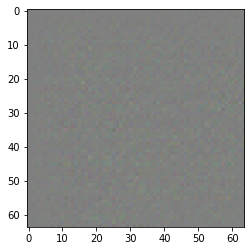

In [17]:
generator = make_generator_model((200,))

noise = np.random.normal(0, 1, 200)

generated_image = generator.predict(np.array([noise]))[0]
plt.imshow(unnormalize_img(generated_image), )

In [18]:
def make_discriminator_model():
    input_layer = Input((64, 64, 3))
    
    x = Conv2D(64, (5, 5), strides=(2, 2), padding='same')(input_layer)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    
    x = Flatten()(x)
    x = Dense(1)(x)
    
    return Model(input_layer, x)

In [19]:
discriminator = make_discriminator_model()
discriminator.summary()
decision = discriminator.predict(np.array([generated_image]))
print (decision)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 128)       0   

In [20]:
cross_entropy = BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [21]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [22]:
def generator_mse_loss(real_img, gen_img):
    return MSE(real_img, gen_img)

In [23]:
generator_optimizer = Adam(1e-4)
# mse_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

In [31]:
@tf.function
def train_step(images):
    noise = tf.random.normal([32, 200])
    
    gen_losses = []
    disc_losses = []
    mse_losses = []

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        mse_loss = 100.0 * tf.reduce_mean(generator_mse_loss(images, generated_images))

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        gen_losses.append(K.mean(gen_loss))
        disc_losses.append(K.mean(disc_loss))
        mse_losses.append(K.mean(mse_loss))
        final_gen_loss = gen_loss + mse_loss

    gradients_of_generator = gen_tape.gradient(final_gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
#     gradients_of_generator_mse = mse_tape.gradient(mse_loss, generator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
#     mse_optimizer.apply_gradients(zip(gradients_of_generator_mse, generator.trainable_variables))
    
    return (gen_losses, disc_losses, mse_losses)

In [1]:
def train(train_imgs, epochs):
    gen_loss_all = []
    disc_loss_all = []
    mse_loss_all = []
    
    num_imgs = len(train_imgs)
    for epoch in range(epochs):
        start = time.time()
        
        gen_loss_epoch = [1, 0]
        disc_loss_epoch = [1, 0]
        mse_loss_epoch = [1, 0]
        
        np.random.shuffle(train_imgs)
        
        for i in range(0, num_imgs - 32, 32):
            gen_loss_batch, disc_loss_batch, mse_loss_batch = train_step(train_imgs[i:(i+32)])

            gen_loss_epoch[0] += 1
            disc_loss_epoch[0] += 1
            mse_loss_epoch[0] += 1
            gen_loss_epoch[1] += np.mean(gen_loss_batch)
            disc_loss_epoch[1] += np.mean(disc_loss_batch)
            mse_loss_epoch[1] += np.mean(mse_loss_batch)
            
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        print(f'Gen loss: {gen_loss_epoch[1]/gen_loss_epoch[0]}, Disc loss: {disc_loss_epoch[1]/disc_loss_epoch[0]}, MSE loss: {mse_loss_epoch[1]/mse_loss_epoch[0]}')
        
        gen_loss_all.append(gen_loss_epoch[1]/gen_loss_epoch[0])
        disc_loss_all.append(disc_loss_epoch[1]/disc_loss_epoch[0])
        mse_loss_all.append(mse_loss_epoch[1]/mse_loss_epoch[0])
    
    return (gen_loss_all, disc_loss_all, mse_loss_all)
    


In [2]:
discriminator = make_discriminator_model()
generator = make_generator_model((200,))
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

NameError: name 'make_discriminator_model' is not defined


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Time for epoch 1 is 9.40933632850647 sec
Gen loss: 3.0783771463849035, Disc loss: 0.1856875423995682, MSE loss: 29.399949226276014
Time for epoch 2 is 7.951054811477661 sec
Gen loss: 4.640704036082033, Disc loss: 0.20756744016542383, MSE loss: 30.25159975377525
Time for epoch 3 is 7.951456308364868 sec
Gen loss: 4.587928165911336, Disc loss: 0.17121633734720632, MSE loss: 29.279407366827574
Time for epoch 4 is 7.946331262588501 sec
Gen loss: 4.288771392853279, Disc loss: 0.146399209518137, MSE loss: 28.372309346186114
Time for epoch 5 is 8.00771713256836 sec
Gen loss: 4.2415694628304585, Disc loss: 0.14629932381667016, MSE loss: 29.010840868239157
Time for epoch 6 is 7.97028374671936 sec
Gen loss: 4.158324266836895, Disc loss: 0.17582635920454412, MSE loss: 30.234140628721654
Time for epoch 7 is 8.086250305175781 sec
Gen loss: 3.8320414742157065, Disc loss: 0.21114253857978152, MSE loss: 30.587038846519903
Time for epoch 8 is 8.377457618713379 sec
Gen loss: 4.229163331391042, Disc loss

Time for epoch 63 is 7.4698486328125 sec
Gen loss: 5.288305577223863, Disc loss: 0.06607682595589781, MSE loss: 27.52566280726818
Time for epoch 64 is 7.614840269088745 sec
Gen loss: 5.372511945765839, Disc loss: 0.0682219338179301, MSE loss: 27.62345405516586
Time for epoch 65 is 7.460742235183716 sec
Gen loss: 5.198096294713214, Disc loss: 0.08489939838970903, MSE loss: 27.835175718395366
Time for epoch 66 is 7.547824144363403 sec
Gen loss: 5.321194405801251, Disc loss: 0.07022392359463786, MSE loss: 27.64346093795487
Time for epoch 67 is 7.594086647033691 sec
Gen loss: 5.319562773717451, Disc loss: 0.07397155949674285, MSE loss: 27.79256097023403
Time for epoch 68 is 7.513559579849243 sec
Gen loss: 5.284345955060426, Disc loss: 0.0793573623384301, MSE loss: 28.05329815934344
Time for epoch 69 is 7.523553371429443 sec
Gen loss: 5.224075804557904, Disc loss: 0.10022192729541118, MSE loss: 28.257867528817194
Time for epoch 70 is 7.600914478302002 sec
Gen loss: 5.287920552540601, Disc l

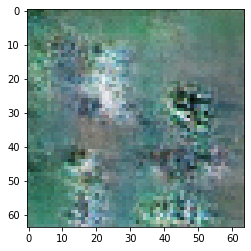

Time for epoch 1 is 7.7123541831970215 sec
Gen loss: 4.843585288298486, Disc loss: 0.1433521605281003, MSE loss: 29.661108911198976
Time for epoch 2 is 7.899966478347778 sec
Gen loss: 4.934535824509494, Disc loss: 0.15205723270622454, MSE loss: 29.77719298158558
Time for epoch 3 is 7.848082542419434 sec
Gen loss: 5.041112840337159, Disc loss: 0.1618855155242208, MSE loss: 29.952411553400964
Time for epoch 4 is 7.482205152511597 sec
Gen loss: 5.028842009826081, Disc loss: 0.1479588541679266, MSE loss: 29.935371233518854
Time for epoch 5 is 7.602769374847412 sec
Gen loss: 5.213541983265864, Disc loss: 0.16406274185992958, MSE loss: 30.14479269632479
Time for epoch 6 is 7.726729393005371 sec
Gen loss: 5.015024993477798, Disc loss: 0.11740680125499078, MSE loss: 29.297735203895467
Time for epoch 7 is 7.6971611976623535 sec
Gen loss: 5.228229267487358, Disc loss: 0.13070780602296395, MSE loss: 29.55167129433898
Time for epoch 8 is 7.641566753387451 sec
Gen loss: 5.127154016236303, Disc loss

Time for epoch 63 is 7.729076385498047 sec
Gen loss: 5.956326001381809, Disc loss: 0.10236643967004165, MSE loss: 29.048725091991063
Time for epoch 64 is 7.836096525192261 sec
Gen loss: 5.930530964197505, Disc loss: 0.08802770930632625, MSE loss: 29.087310429187973
Time for epoch 65 is 7.559267520904541 sec
Gen loss: 6.011980384992067, Disc loss: 0.13996227251032625, MSE loss: 30.007510916650457
Time for epoch 66 is 7.568234920501709 sec
Gen loss: 5.911088062172659, Disc loss: 0.10662313995549713, MSE loss: 29.559907535873453
Time for epoch 67 is 7.563689708709717 sec
Gen loss: 5.898653512401633, Disc loss: 0.09996978492857156, MSE loss: 29.41971502329922
Time for epoch 68 is 7.555002927780151 sec
Gen loss: 5.870926125585871, Disc loss: 0.09578372591722828, MSE loss: 29.088956677816746
Time for epoch 69 is 7.569463729858398 sec
Gen loss: 5.822436459342316, Disc loss: 0.10128441296497658, MSE loss: 29.526419052909706
Time for epoch 70 is 7.559668779373169 sec
Gen loss: 6.152949766091861

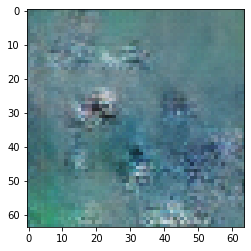

Time for epoch 1 is 7.44689416885376 sec
Gen loss: 6.465145677085815, Disc loss: 0.09331327606734585, MSE loss: 29.70429560550183
Time for epoch 2 is 7.545072793960571 sec
Gen loss: 6.613605439824464, Disc loss: 0.09117203748874558, MSE loss: 29.177112222687015
Time for epoch 3 is 7.609447240829468 sec
Gen loss: 6.8042790766977035, Disc loss: 0.1061048563740148, MSE loss: 29.339555890256474
Time for epoch 4 is 7.6096274852752686 sec
Gen loss: 6.528862730920476, Disc loss: 0.11027207769021936, MSE loss: 30.21647598556064
Time for epoch 5 is 7.575229167938232 sec
Gen loss: 6.450636331304948, Disc loss: 0.09944424562712723, MSE loss: 29.393774120465203
Time for epoch 6 is 7.484344959259033 sec
Gen loss: 6.505513869649995, Disc loss: 0.09647381385450117, MSE loss: 29.65553314705205
Time for epoch 7 is 7.4931652545928955 sec
Gen loss: 6.676420520637739, Disc loss: 0.10955546897972321, MSE loss: 29.773580204826708
Time for epoch 8 is 7.603264570236206 sec
Gen loss: 6.288637463639422, Disc lo

Time for epoch 63 is 7.508504390716553 sec
Gen loss: 7.764981963770176, Disc loss: 0.07228571122197837, MSE loss: 31.45201578114414
Time for epoch 64 is 7.603321313858032 sec
Gen loss: 6.6603821842328, Disc loss: 0.11445869052363686, MSE loss: 30.740892813457705
Time for epoch 65 is 7.608429908752441 sec
Gen loss: 6.758117275186348, Disc loss: 0.10065123796062973, MSE loss: 29.580092665302722
Time for epoch 66 is 7.520567417144775 sec
Gen loss: 6.837676941217769, Disc loss: 0.10111718062566326, MSE loss: 29.881899996501645
Time for epoch 67 is 7.52626371383667 sec
Gen loss: 7.675838001375276, Disc loss: 0.09988144068564805, MSE loss: 29.795993189824628
Time for epoch 68 is 7.529631853103638 sec
Gen loss: 6.5321569158455866, Disc loss: 0.08205444365045747, MSE loss: 29.069798353241712
Time for epoch 69 is 7.589043855667114 sec
Gen loss: 6.568007491145353, Disc loss: 0.07824703471086475, MSE loss: 29.377615341972206
Time for epoch 70 is 7.703372001647949 sec
Gen loss: 6.596655628545498, 

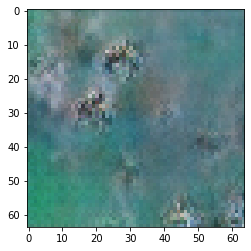

Time for epoch 1 is 7.510843753814697 sec
Gen loss: 6.967510220804189, Disc loss: 0.08098375409409948, MSE loss: 29.37501243653336
Time for epoch 2 is 7.556147813796997 sec
Gen loss: 6.918168440097716, Disc loss: 0.07178853193441845, MSE loss: 29.05686191879314
Time for epoch 3 is 7.607086181640625 sec
Gen loss: 6.852344073577302, Disc loss: 0.08052499642025246, MSE loss: 29.496371566441645
Time for epoch 4 is 7.609740734100342 sec
Gen loss: 6.741318776355526, Disc loss: 0.08910081380609736, MSE loss: 29.480932101324644
Time for epoch 5 is 7.573570013046265 sec
Gen loss: 6.620062112162107, Disc loss: 0.06948185069133152, MSE loss: 29.16052937184569
Time for epoch 6 is 7.5732622146606445 sec
Gen loss: 6.817664933398487, Disc loss: 0.08252872720355708, MSE loss: 29.59492128263644
Time for epoch 7 is 7.546663522720337 sec
Gen loss: 6.94775822621374, Disc loss: 0.088843635605209, MSE loss: 29.519576163149786
Time for epoch 8 is 7.563369989395142 sec
Gen loss: 7.041411053520554, Disc loss: 

Time for epoch 63 is 7.600575685501099 sec
Gen loss: 6.693215503279109, Disc loss: 0.08784203489215131, MSE loss: 29.668261329009926
Time for epoch 64 is 7.450552701950073 sec
Gen loss: 6.80976723203168, Disc loss: 0.09370592257435759, MSE loss: 29.540280417052063
Time for epoch 65 is 7.613865852355957 sec
Gen loss: 6.568272152567298, Disc loss: 0.09347635999935247, MSE loss: 29.87180453975026
Time for epoch 66 is 7.469013214111328 sec
Gen loss: 6.852268343049336, Disc loss: 0.0983342373665412, MSE loss: 30.022590001424152
Time for epoch 67 is 7.6477131843566895 sec
Gen loss: 6.620577390924056, Disc loss: 0.10628021497160782, MSE loss: 30.10409050711448
Time for epoch 68 is 7.554810047149658 sec
Gen loss: 7.692578466927133, Disc loss: 0.12781641096957874, MSE loss: 30.934561690663905
Time for epoch 69 is 7.494720697402954 sec
Gen loss: 6.636244457265549, Disc loss: 0.1242081382132683, MSE loss: 29.94845949601998
Time for epoch 70 is 7.57305908203125 sec
Gen loss: 6.688018433123746, Dis

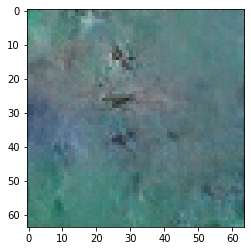

Time for epoch 1 is 7.480166912078857 sec
Gen loss: 7.067148635057899, Disc loss: 0.10381454352837127, MSE loss: 29.356261628107003
Time for epoch 2 is 7.541096925735474 sec
Gen loss: 7.142972262571175, Disc loss: 0.1246897116411341, MSE loss: 29.451435709387308
Time for epoch 3 is 7.607425212860107 sec
Gen loss: 7.1062168713184555, Disc loss: 0.12387809997580966, MSE loss: 29.209511397653802
Time for epoch 4 is 7.468522071838379 sec
Gen loss: 6.820453873817836, Disc loss: 0.10043652679945966, MSE loss: 29.025471896660036
Time for epoch 5 is 7.660590648651123 sec
Gen loss: 6.909958322519856, Disc loss: 0.10144463486510119, MSE loss: 28.89441853034787
Time for epoch 6 is 7.493211984634399 sec
Gen loss: 6.807409059064498, Disc loss: 0.1077074479244821, MSE loss: 28.83353649956101
Time for epoch 7 is 7.536765098571777 sec
Gen loss: 6.899696724847726, Disc loss: 0.10695029263760703, MSE loss: 28.963199269157762
Time for epoch 8 is 7.546627521514893 sec
Gen loss: 7.8117141439339655, Disc lo

Time for epoch 63 is 7.5042243003845215 sec
Gen loss: 6.991320020784207, Disc loss: 0.10439955751912613, MSE loss: 29.638488397365663
Time for epoch 64 is 7.51059889793396 sec
Gen loss: 8.02866422839281, Disc loss: 0.1367345333296467, MSE loss: 29.71667302656303
Time for epoch 65 is 7.58706259727478 sec
Gen loss: 6.561079054990112, Disc loss: 0.12561633471313732, MSE loss: 29.75907717035392
Time for epoch 66 is 7.495211601257324 sec
Gen loss: 6.436425816398972, Disc loss: 0.10216980269254465, MSE loss: 29.208549034304735
Time for epoch 67 is 7.610458135604858 sec
Gen loss: 6.471108781612985, Disc loss: 0.09563447372498228, MSE loss: 29.299563994575646
Time for epoch 68 is 7.482487916946411 sec
Gen loss: 6.586415598386026, Disc loss: 0.10824142451471268, MSE loss: 29.343082515850945
Time for epoch 69 is 7.480044364929199 sec
Gen loss: 6.492266147117305, Disc loss: 0.09203176264938845, MSE loss: 29.328971966172297
Time for epoch 70 is 7.512765169143677 sec
Gen loss: 6.623909470834707, Di

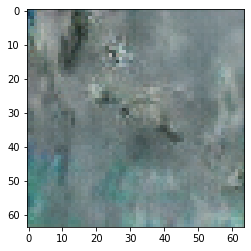

Time for epoch 1 is 7.6234002113342285 sec
Gen loss: 6.615666799105926, Disc loss: 0.11421639471362802, MSE loss: 29.63603965635222
Time for epoch 2 is 7.470698833465576 sec
Gen loss: 6.367292972761118, Disc loss: 0.09714319245122514, MSE loss: 29.46256623100136
Time for epoch 3 is 7.581620454788208 sec
Gen loss: 6.727644451265412, Disc loss: 0.10812814629871428, MSE loss: 29.47688479022928
Time for epoch 4 is 7.591767072677612 sec
Gen loss: 6.506896165005236, Disc loss: 0.11016730993461156, MSE loss: 29.83593701411715
Time for epoch 5 is 7.497636556625366 sec
Gen loss: 6.410910004199682, Disc loss: 0.10505621090498539, MSE loss: 29.644693855347672
Time for epoch 6 is 7.5005714893341064 sec
Gen loss: 7.010117731120205, Disc loss: 0.11227584059752756, MSE loss: 29.792952798569427
Time for epoch 7 is 7.4920125007629395 sec
Gen loss: 6.67338696921744, Disc loss: 0.09034069809875878, MSE loss: 29.45092139722209
Time for epoch 8 is 7.502726793289185 sec
Gen loss: 6.914603839398723, Disc los

Time for epoch 63 is 7.460632085800171 sec
Gen loss: 6.53333415442366, Disc loss: 0.092504676277459, MSE loss: 29.53376092368025
Time for epoch 64 is 7.614479064941406 sec
Gen loss: 6.460096398020179, Disc loss: 0.07926722126760517, MSE loss: 29.574601542981984
Time for epoch 65 is 7.489656209945679 sec
Gen loss: 6.516325579749213, Disc loss: 0.08802304556214713, MSE loss: 29.64137805122024
Time for epoch 66 is 7.543710231781006 sec
Gen loss: 9.820321885550895, Disc loss: 0.06480723275801585, MSE loss: 30.437168100662024
Time for epoch 67 is 7.555306673049927 sec
Gen loss: 6.600698950490977, Disc loss: 0.11884164082158993, MSE loss: 30.235269536170858
Time for epoch 68 is 7.554335594177246 sec
Gen loss: 6.609617204847051, Disc loss: 0.09979559169062552, MSE loss: 30.063203460155787
Time for epoch 69 is 7.469731569290161 sec
Gen loss: 6.495823460865796, Disc loss: 0.08826038078594256, MSE loss: 29.87594856737752
Time for epoch 70 is 7.473534107208252 sec
Gen loss: 6.543847638417065, Dis

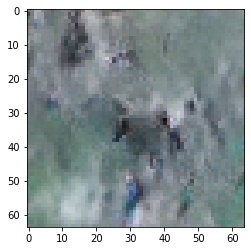

Time for epoch 1 is 7.531307697296143 sec
Gen loss: 6.549344242426761, Disc loss: 0.07960875681538367, MSE loss: 29.50425084431966
Time for epoch 2 is 7.454027414321899 sec
Gen loss: 6.57517334439244, Disc loss: 0.08305031601730785, MSE loss: 29.561276262691674
Time for epoch 3 is 7.585422992706299 sec
Gen loss: 6.3995070470380915, Disc loss: 0.08951310154560418, MSE loss: 29.760981371086142
Time for epoch 4 is 7.585095643997192 sec
Gen loss: 6.551298142771734, Disc loss: 0.08556549936699552, MSE loss: 29.837617956848973
Time for epoch 5 is 7.497512578964233 sec
Gen loss: 6.587651516363873, Disc loss: 0.08740430996251017, MSE loss: 29.67505510841928
Time for epoch 6 is 7.480072259902954 sec
Gen loss: 6.513268784778874, Disc loss: 0.08985639138710066, MSE loss: 29.84978586419165
Time for epoch 7 is 7.512770175933838 sec
Gen loss: 6.64320109530193, Disc loss: 0.09327499109489444, MSE loss: 29.83475233868855
Time for epoch 8 is 7.6152167320251465 sec
Gen loss: 7.6177225552277195, Disc los

Time for epoch 63 is 7.597440719604492 sec
Gen loss: 6.72842317544994, Disc loss: 0.1109277809910769, MSE loss: 29.941637566419153
Time for epoch 64 is 7.451780080795288 sec
Gen loss: 6.42242119176601, Disc loss: 0.09312914031858084, MSE loss: 30.095328235367774
Time for epoch 65 is 7.655431032180786 sec
Gen loss: 7.6590652956872125, Disc loss: 0.0930465376155814, MSE loss: 29.99689182291832
Time for epoch 66 is 7.461738109588623 sec
Gen loss: 7.71185083505584, Disc loss: 0.12434871614228851, MSE loss: 30.7792562055717
Time for epoch 67 is 7.5037078857421875 sec
Gen loss: 6.742496659762168, Disc loss: 0.10801863420608285, MSE loss: 30.364002770524685
Time for epoch 68 is 7.507502317428589 sec
Gen loss: 6.476418521023055, Disc loss: 0.12351286936132364, MSE loss: 30.390378967533266
Time for epoch 69 is 7.531101942062378 sec
Gen loss: 6.43265256390662, Disc loss: 0.09204274253177691, MSE loss: 29.975295364049067
Time for epoch 70 is 7.607426166534424 sec
Gen loss: 6.44275926574459, Disc 

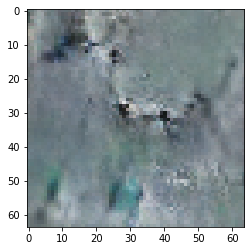

Time for epoch 1 is 7.549007177352905 sec
Gen loss: 6.429729902324315, Disc loss: 0.09098393240751734, MSE loss: 29.95199776729594
Time for epoch 2 is 7.456751585006714 sec
Gen loss: 7.9656488242834245, Disc loss: 0.09641969577424471, MSE loss: 30.39598115543686
Time for epoch 3 is 7.466496706008911 sec
Gen loss: 6.427135508881029, Disc loss: 0.1230124622510196, MSE loss: 30.572759230285477
Time for epoch 4 is 7.622323751449585 sec
Gen loss: 6.443672996872486, Disc loss: 0.10585823758230178, MSE loss: 30.25909112139446
Time for epoch 5 is 7.488195180892944 sec
Gen loss: 6.3118553135776265, Disc loss: 0.1059284634559433, MSE loss: 30.310522353422996
Time for epoch 6 is 7.498671293258667 sec
Gen loss: 6.4559558193858075, Disc loss: 0.09184961292014374, MSE loss: 30.094933631297373
Time for epoch 7 is 7.499249696731567 sec
Gen loss: 6.408881708212339, Disc loss: 0.10220651150186393, MSE loss: 30.17392544630097
Time for epoch 8 is 7.501478910446167 sec
Gen loss: 6.29666282426374, Disc loss

Time for epoch 64 is 7.449178218841553 sec
Gen loss: 6.5238056492999315, Disc loss: 0.08282452647140133, MSE loss: 29.77983362047976
Time for epoch 65 is 7.492148160934448 sec
Gen loss: 6.697155868457908, Disc loss: 0.08954954859018224, MSE loss: 30.028546201504344
Time for epoch 66 is 7.5349109172821045 sec
Gen loss: 8.26655617509754, Disc loss: 0.1018318367430391, MSE loss: 30.444096790096623
Time for epoch 67 is 7.609782457351685 sec
Gen loss: 6.75059737487214, Disc loss: 0.10699891440253603, MSE loss: 30.515392939249676
Time for epoch 68 is 7.505202770233154 sec
Gen loss: 6.589262734906783, Disc loss: 0.09574067001773655, MSE loss: 30.11043523772945
Time for epoch 69 is 7.479402780532837 sec
Gen loss: 6.546229228094664, Disc loss: 0.09662706899232051, MSE loss: 30.20585859758744
Time for epoch 70 is 7.608157396316528 sec
Gen loss: 6.377498759809871, Disc loss: 0.08114997106654756, MSE loss: 29.93970266202601
Time for epoch 71 is 7.444885492324829 sec
Gen loss: 6.517631309788402, Di

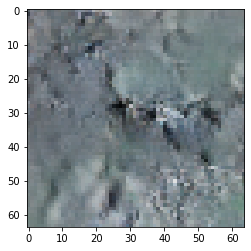

Time for epoch 1 is 7.565338850021362 sec
Gen loss: 6.574195268677502, Disc loss: 0.08700543152468738, MSE loss: 30.04876579760213
Time for epoch 2 is 7.4943931102752686 sec
Gen loss: 6.652381097075093, Disc loss: 0.09279476262586125, MSE loss: 30.022102376632898
Time for epoch 3 is 7.607017755508423 sec
Gen loss: 6.640649765810669, Disc loss: 0.09121370093763218, MSE loss: 30.030210805133105
Time for epoch 4 is 7.457818031311035 sec
Gen loss: 6.688169503922708, Disc loss: 0.07945674668737564, MSE loss: 29.7781793341081
Time for epoch 5 is 7.514427185058594 sec
Gen loss: 6.520235345938665, Disc loss: 0.0782068368264532, MSE loss: 29.570220756013864
Time for epoch 6 is 7.6109278202056885 sec
Gen loss: 6.657641321662965, Disc loss: 0.0872281844838747, MSE loss: 30.013852085847518
Time for epoch 7 is 7.4774696826934814 sec
Gen loss: 6.690775607659565, Disc loss: 0.08025621700347944, MSE loss: 29.90021032628005
Time for epoch 8 is 7.553937911987305 sec
Gen loss: 6.639910522192151, Disc los

Time for epoch 63 is 7.502978563308716 sec
Gen loss: 6.58749090365278, Disc loss: 0.08300412058335575, MSE loss: 30.00034228896061
Time for epoch 64 is 7.517029523849487 sec
Gen loss: 6.490540143920154, Disc loss: 0.08284582709262607, MSE loss: 30.169931437587998
Time for epoch 65 is 7.489788055419922 sec
Gen loss: 6.622308215474694, Disc loss: 0.07952787843722153, MSE loss: 29.947724319085843
Time for epoch 66 is 7.496646165847778 sec
Gen loss: 6.763997318298836, Disc loss: 0.0828910429916549, MSE loss: 29.896525799097407
Time for epoch 67 is 7.50215482711792 sec
Gen loss: 6.746697626139737, Disc loss: 0.08162893869770252, MSE loss: 30.00888622356301
Time for epoch 68 is 7.500465631484985 sec
Gen loss: 6.820184823943348, Disc loss: 0.08772309392761328, MSE loss: 29.801343964367376
Time for epoch 69 is 7.605487108230591 sec
Gen loss: 6.738716449840928, Disc loss: 0.0779486812776091, MSE loss: 29.786260460127338
Time for epoch 70 is 7.42629599571228 sec
Gen loss: 6.914747178716065, Disc

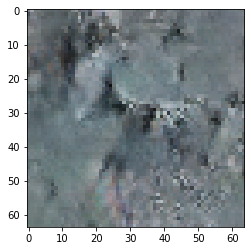

Time for epoch 1 is 7.467017650604248 sec
Gen loss: 6.705361314582308, Disc loss: 0.06959056726979915, MSE loss: 29.847202192477095
Time for epoch 2 is 7.499639272689819 sec
Gen loss: 6.788352738874068, Disc loss: 0.07243427605214238, MSE loss: 29.830203663689012
Time for epoch 3 is 7.617300033569336 sec
Gen loss: 6.842234103660274, Disc loss: 0.07791037005334486, MSE loss: 29.860544840494793
Time for epoch 4 is 7.3942131996154785 sec
Gen loss: 6.840978123631258, Disc loss: 0.07820191563341797, MSE loss: 29.928972099531634
Time for epoch 5 is 7.540981292724609 sec
Gen loss: 6.862847709397314, Disc loss: 0.08514656473662917, MSE loss: 30.145740023150353
Time for epoch 6 is 7.572472333908081 sec
Gen loss: 6.883248223198785, Disc loss: 0.08233411261006725, MSE loss: 30.138504322951402
Time for epoch 7 is 7.42933201789856 sec
Gen loss: 6.747829445009309, Disc loss: 0.07376105105630588, MSE loss: 30.05322980493065
Time for epoch 8 is 7.596320629119873 sec
Gen loss: 6.7566933476827975, Disc 

Time for epoch 63 is 7.495323181152344 sec
Gen loss: 7.16869608690422, Disc loss: 0.07861433998583173, MSE loss: 30.16696347389118
Time for epoch 64 is 7.492464542388916 sec
Gen loss: 6.992418787989836, Disc loss: 0.08360106516679935, MSE loss: 30.14716314300289
Time for epoch 65 is 7.491473197937012 sec
Gen loss: 7.05842026527012, Disc loss: 0.07325037638152013, MSE loss: 29.991816895440987
Time for epoch 66 is 7.511291742324829 sec
Gen loss: 7.021807462542361, Disc loss: 0.07660493051739244, MSE loss: 29.877305979328103
Time for epoch 67 is 7.502305507659912 sec
Gen loss: 7.220041051466613, Disc loss: 0.07354666241873711, MSE loss: 29.884682554539626
Time for epoch 68 is 7.498622179031372 sec
Gen loss: 6.9945572398219324, Disc loss: 0.06294787872512005, MSE loss: 29.81071857255972
Time for epoch 69 is 7.481457948684692 sec
Gen loss: 7.7965793557929475, Disc loss: 0.07267750011340414, MSE loss: 29.954891551154738
Time for epoch 70 is 7.490783452987671 sec
Gen loss: 8.15200312673884, D

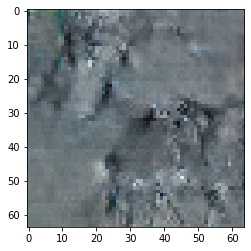

Time for epoch 1 is 7.4963438510894775 sec
Gen loss: 7.337661905986507, Disc loss: 0.10429860626380173, MSE loss: 30.69462367318833
Time for epoch 2 is 7.4953672885894775 sec
Gen loss: 7.177324513432779, Disc loss: 0.0776710100232202, MSE loss: 30.03689126012125
Time for epoch 3 is 7.508786916732788 sec
Gen loss: 7.0745854209755175, Disc loss: 0.06335621991707138, MSE loss: 29.691253450181748
Time for epoch 4 is 7.498773097991943 sec
Gen loss: 7.213468737718536, Disc loss: 0.07632717772716338, MSE loss: 29.7791019946256
Time for epoch 5 is 7.4343483448028564 sec
Gen loss: 7.188460064451223, Disc loss: 0.06689282185536857, MSE loss: 29.579203463505277
Time for epoch 6 is 7.482301712036133 sec
Gen loss: 7.07141170656778, Disc loss: 0.07185719802983226, MSE loss: 29.957405715776975
Time for epoch 7 is 7.4998533725738525 sec
Gen loss: 6.974097912227558, Disc loss: 0.07524647111348243, MSE loss: 29.884115244961045
Time for epoch 8 is 7.483259916305542 sec
Gen loss: 7.114818346855763, Disc l

Time for epoch 63 is 7.516466856002808 sec
Gen loss: 7.072421701943002, Disc loss: 0.06792717051741523, MSE loss: 29.962658341984117
Time for epoch 64 is 7.465680837631226 sec
Gen loss: 7.076416045346558, Disc loss: 0.06839960044865726, MSE loss: 29.68859084318001
Time for epoch 65 is 7.535090208053589 sec
Gen loss: 7.0042460966239455, Disc loss: 0.0644043483235053, MSE loss: 29.87893702085748
Time for epoch 66 is 7.471033573150635 sec
Gen loss: 7.04315100258928, Disc loss: 0.07267205000458775, MSE loss: 29.987853037309517
Time for epoch 67 is 7.608673572540283 sec
Gen loss: 7.101650607618213, Disc loss: 0.07090554391835288, MSE loss: 29.93262502365319
Time for epoch 68 is 7.5011773109436035 sec
Gen loss: 8.036106846196864, Disc loss: 0.08568943395477475, MSE loss: 30.473929960876298
Time for epoch 69 is 7.492018699645996 sec
Gen loss: 7.39982527833644, Disc loss: 0.08332336091458215, MSE loss: 30.54137967530951
Time for epoch 70 is 7.508734464645386 sec
Gen loss: 7.062643690807064, Di

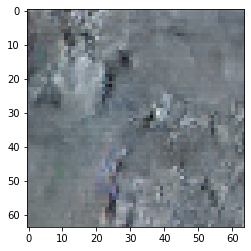

Time for epoch 1 is 7.527838230133057 sec
Gen loss: 7.146812068091498, Disc loss: 0.07688520310842874, MSE loss: 30.165774787344585
Time for epoch 2 is 7.522393703460693 sec
Gen loss: 8.200600401818914, Disc loss: 0.07338804800862662, MSE loss: 30.880413262178582
Time for epoch 3 is 7.543523073196411 sec
Gen loss: 6.984679600733728, Disc loss: 0.09112331514665731, MSE loss: 30.558117786397133
Time for epoch 4 is 7.520771265029907 sec
Gen loss: 6.995789538231, Disc loss: 0.07864914809575754, MSE loss: 30.454594304568076
Time for epoch 5 is 7.487946033477783 sec
Gen loss: 6.923491227271434, Disc loss: 0.06552282707616788, MSE loss: 30.038075165373847
Time for epoch 6 is 7.575777769088745 sec
Gen loss: 6.915295307552265, Disc loss: 0.0702780195428904, MSE loss: 30.100409732601506
Time for epoch 7 is 7.479713678359985 sec
Gen loss: 7.226340707401596, Disc loss: 0.06885046981020167, MSE loss: 30.001071242459098
Time for epoch 8 is 7.475309610366821 sec
Gen loss: 7.860238877738395, Disc loss

Time for epoch 63 is 7.568648099899292 sec
Gen loss: 7.051297452714708, Disc loss: 0.06816346311833214, MSE loss: 29.803950028044746
Time for epoch 64 is 7.4525933265686035 sec
Gen loss: 6.937412473890516, Disc loss: 0.07254268787454228, MSE loss: 29.928803694603566
Time for epoch 65 is 7.459889650344849 sec
Gen loss: 7.150600952830741, Disc loss: 0.07526524633586881, MSE loss: 29.860921074058304
Time for epoch 66 is 7.491400957107544 sec
Gen loss: 7.1390941769773075, Disc loss: 0.07877529466393476, MSE loss: 30.111036455728176
Time for epoch 67 is 7.630210638046265 sec
Gen loss: 7.020120875299138, Disc loss: 0.06325961151892233, MSE loss: 29.759043122371683
Time for epoch 68 is 7.450850248336792 sec
Gen loss: 7.138249879283957, Disc loss: 0.08621543772306627, MSE loss: 30.237716106218375
Time for epoch 69 is 7.478203296661377 sec
Gen loss: 7.19103103989185, Disc loss: 0.07893162716633127, MSE loss: 30.12302151088146
Time for epoch 70 is 7.557096481323242 sec
Gen loss: 7.17644207393573

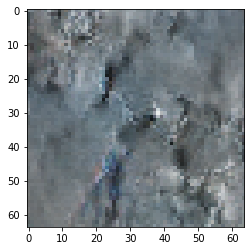

Time for epoch 1 is 7.476171016693115 sec
Gen loss: 7.032425797728665, Disc loss: 0.0848991445273282, MSE loss: 30.321990966796875
Time for epoch 2 is 7.564105033874512 sec
Gen loss: 7.5136664902291646, Disc loss: 0.09145307311407092, MSE loss: 30.60154231001691
Time for epoch 3 is 7.5110626220703125 sec
Gen loss: 7.243649237201143, Disc loss: 0.09451811526697583, MSE loss: 30.671104560376506
Time for epoch 4 is 7.48243522644043 sec
Gen loss: 7.09050734062505, Disc loss: 0.0858246653169131, MSE loss: 30.266010889192906
Time for epoch 5 is 7.4885759353637695 sec
Gen loss: 6.926177435774144, Disc loss: 0.06634370349334971, MSE loss: 29.77318613832882
Time for epoch 6 is 7.484414339065552 sec
Gen loss: 7.071633372526505, Disc loss: 0.05882424287886679, MSE loss: 29.76524230522838
Time for epoch 7 is 7.475085258483887 sec
Gen loss: 7.092095201900658, Disc loss: 0.07042397998827371, MSE loss: 30.017624278701742
Time for epoch 8 is 7.48134708404541 sec
Gen loss: 7.074711591570681, Disc loss:

Time for epoch 63 is 7.571963548660278 sec
Gen loss: 6.9710787512099515, Disc loss: 0.06353931367519718, MSE loss: 29.86166819647399
Time for epoch 64 is 7.421736478805542 sec
Gen loss: 7.149557920006233, Disc loss: 0.061558923760408835, MSE loss: 29.89139278277472
Time for epoch 65 is 7.608941316604614 sec
Gen loss: 7.033950368886394, Disc loss: 0.06311760074111979, MSE loss: 29.889908477865905
Time for epoch 66 is 7.44978666305542 sec
Gen loss: 7.0937908529266105, Disc loss: 0.07637968588794573, MSE loss: 30.2536337007352
Time for epoch 67 is 7.4817423820495605 sec
Gen loss: 6.969122935762896, Disc loss: 0.07642792079277175, MSE loss: 30.312520014238228
Time for epoch 68 is 7.552299737930298 sec
Gen loss: 7.089032630610272, Disc loss: 0.06591114647141318, MSE loss: 30.040277594796365
Time for epoch 69 is 7.55057168006897 sec
Gen loss: 7.013278337028938, Disc loss: 0.07621185061001903, MSE loss: 30.24812802777381
Time for epoch 70 is 7.545147895812988 sec
Gen loss: 7.536657932974135, 

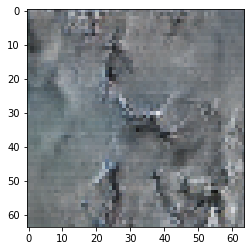

Time for epoch 1 is 7.441897392272949 sec
Gen loss: 7.1340506923231, Disc loss: 0.0733273334272438, MSE loss: 30.249427733382557
Time for epoch 2 is 7.636354923248291 sec
Gen loss: 7.120313344609124, Disc loss: 0.06264218316744094, MSE loss: 29.895442735211958
Time for epoch 3 is 7.4534752368927 sec
Gen loss: 7.170254035370783, Disc loss: 0.06488961187020313, MSE loss: 29.771345169563602
Time for epoch 4 is 7.580094575881958 sec
Gen loss: 7.172508250084027, Disc loss: 0.05547517153111395, MSE loss: 29.764939713930374
Time for epoch 5 is 7.503149032592773 sec
Gen loss: 7.130680082936274, Disc loss: 0.060704382645662844, MSE loss: 29.849430228959577
Time for epoch 6 is 7.52362847328186 sec
Gen loss: 7.139018284919139, Disc loss: 0.05794689369319779, MSE loss: 29.802308297092676
Time for epoch 7 is 7.609849691390991 sec
Gen loss: 7.253651103353112, Disc loss: 0.06380017887236838, MSE loss: 29.96642638415825
Time for epoch 8 is 7.545111656188965 sec
Gen loss: 7.133760721056765, Disc loss: 

Time for epoch 63 is 7.496729135513306 sec
Gen loss: 7.0992596789104185, Disc loss: 0.06620842940994313, MSE loss: 30.08005511276121
Time for epoch 64 is 7.50809645652771 sec
Gen loss: 7.2291651301913795, Disc loss: 0.07262599440657491, MSE loss: 30.174359138095927
Time for epoch 65 is 7.5269553661346436 sec
Gen loss: 7.25095849954662, Disc loss: 0.07338613512683509, MSE loss: 30.16197643951995
Time for epoch 66 is 7.487795829772949 sec
Gen loss: 7.181470191252587, Disc loss: 0.07181385141320346, MSE loss: 30.17772259492538
Time for epoch 67 is 7.491360187530518 sec
Gen loss: 7.157044859113409, Disc loss: 0.06453994955478846, MSE loss: 30.009278527443325
Time for epoch 68 is 7.5030152797698975 sec
Gen loss: 7.236611441221987, Disc loss: 0.07279775487252721, MSE loss: 30.118775701135153
Time for epoch 69 is 7.503681898117065 sec
Gen loss: 7.209736763300288, Disc loss: 0.06938587617934215, MSE loss: 30.145705732226695
Time for epoch 70 is 7.4908788204193115 sec
Gen loss: 7.36638753394770

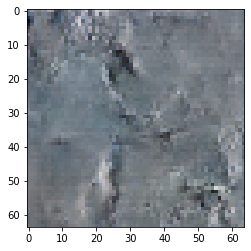

Time for epoch 1 is 7.442746877670288 sec
Gen loss: 7.121497336441909, Disc loss: 0.06964203255562752, MSE loss: 30.173369994331505
Time for epoch 2 is 7.529847860336304 sec
Gen loss: 7.147223764641821, Disc loss: 0.06725176730064478, MSE loss: 30.007597822483962
Time for epoch 3 is 7.54787802696228 sec
Gen loss: 7.219216326064856, Disc loss: 0.07112663476614327, MSE loss: 30.13412428031446
Time for epoch 4 is 7.4142906665802 sec
Gen loss: 7.229565184936937, Disc loss: 0.07319291638901967, MSE loss: 30.05228607053679
Time for epoch 5 is 7.463907480239868 sec
Gen loss: 8.968770093064967, Disc loss: 0.10899008789240461, MSE loss: 30.666047936209495
Time for epoch 6 is 7.489201307296753 sec
Gen loss: 8.669010593962216, Disc loss: 0.12613086057161196, MSE loss: 31.112074828729398
Time for epoch 7 is 7.586110353469849 sec
Gen loss: 7.410928518145388, Disc loss: 0.08988388493684875, MSE loss: 30.661162885547007
Time for epoch 8 is 7.473907232284546 sec
Gen loss: 7.162751306363238, Disc loss:

Time for epoch 63 is 7.462658166885376 sec
Gen loss: 7.494246096468876, Disc loss: 0.07137209855728002, MSE loss: 30.2797293107361
Time for epoch 64 is 7.475722551345825 sec
Gen loss: 7.2310253546489935, Disc loss: 0.0676063104951628, MSE loss: 30.343639699424184
Time for epoch 65 is 7.476080417633057 sec
Gen loss: 7.216518575259987, Disc loss: 0.06265810422181609, MSE loss: 29.924024540557447
Time for epoch 66 is 7.46821665763855 sec
Gen loss: 7.707237048523859, Disc loss: 0.07674335058195501, MSE loss: 30.13322880856067
Time for epoch 67 is 7.513439893722534 sec
Gen loss: 7.2003209015864345, Disc loss: 0.0737208570183323, MSE loss: 30.22616986530583
Time for epoch 68 is 7.5534141063690186 sec
Gen loss: 9.496793404504212, Disc loss: 0.10873501741280495, MSE loss: 31.14828950732058
Time for epoch 69 is 7.4870924949646 sec
Gen loss: 7.910380854516172, Disc loss: 0.09125957646243764, MSE loss: 31.05563718387428
Time for epoch 70 is 7.462886095046997 sec
Gen loss: 7.50471839155285, Disc l

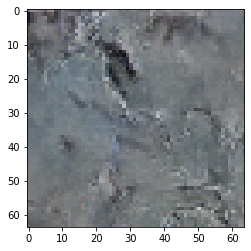

Time for epoch 1 is 7.454784154891968 sec
Gen loss: 7.307709354049145, Disc loss: 0.06619868012158413, MSE loss: 30.171691015806946
Time for epoch 2 is 7.605691432952881 sec
Gen loss: 7.224713820429029, Disc loss: 0.06737588325371527, MSE loss: 30.20562531179206
Time for epoch 3 is 7.4696409702301025 sec
Gen loss: 7.488859249001273, Disc loss: 0.07320557456768968, MSE loss: 30.255680544266532
Time for epoch 4 is 7.527511119842529 sec
Gen loss: 7.345279861594927, Disc loss: 0.07114127178822813, MSE loss: 30.117427986165694
Time for epoch 5 is 7.464349985122681 sec
Gen loss: 9.418338170865686, Disc loss: 0.0925634052472034, MSE loss: 30.730397335559047
Time for epoch 6 is 7.498605012893677 sec
Gen loss: 8.061262801410706, Disc loss: 0.09528211346050715, MSE loss: 30.985438618233534
Time for epoch 7 is 7.568460941314697 sec
Gen loss: 7.357999013368353, Disc loss: 0.07553594979283408, MSE loss: 30.594362279587
Time for epoch 8 is 7.552689552307129 sec
Gen loss: 7.155085960377845, Disc loss

Time for epoch 63 is 7.526006460189819 sec
Gen loss: 7.303445659678803, Disc loss: 0.07441152705997733, MSE loss: 30.228066023126203
Time for epoch 64 is 7.521852731704712 sec
Gen loss: 7.3860006926828605, Disc loss: 0.06991587688993071, MSE loss: 30.245771330546557
Time for epoch 65 is 7.516715049743652 sec
Gen loss: 7.470624709193945, Disc loss: 0.07149248497278574, MSE loss: 30.40474962994335
Time for epoch 66 is 7.481679677963257 sec
Gen loss: 7.26992429950373, Disc loss: 0.07116040063714028, MSE loss: 30.31439685563085
Time for epoch 67 is 7.644612789154053 sec
Gen loss: 9.491928349988571, Disc loss: 0.09755010410529993, MSE loss: 30.863898827777646
Time for epoch 68 is 7.439264297485352 sec
Gen loss: 8.650472025884199, Disc loss: 0.13699746362799192, MSE loss: 31.512907343505198
Time for epoch 69 is 7.454643964767456 sec
Gen loss: 9.351584933314543, Disc loss: 0.0997168700336985, MSE loss: 31.3679104833422
Time for epoch 70 is 7.6380226612091064 sec
Gen loss: 7.355558991109129, D

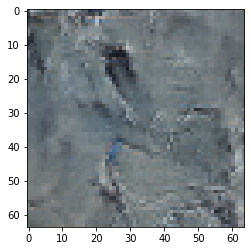

Time for epoch 1 is 7.603170156478882 sec
Gen loss: 7.504009461338281, Disc loss: 0.07651148132868187, MSE loss: 30.267991456235972
Time for epoch 2 is 7.497798681259155 sec
Gen loss: 8.065990237362662, Disc loss: 0.06724385057416994, MSE loss: 29.90462945664155
Time for epoch 3 is 7.521404504776001 sec
Gen loss: 8.251333573969399, Disc loss: 0.0970423709034704, MSE loss: 30.644215053982204
Time for epoch 4 is 7.510816335678101 sec
Gen loss: 7.259535339789662, Disc loss: 0.08391441220416357, MSE loss: 30.56015411108167
Time for epoch 5 is 7.528281211853027 sec
Gen loss: 7.59038251266893, Disc loss: 0.06975635114948701, MSE loss: 30.116392099437352
Time for epoch 6 is 7.4486963748931885 sec
Gen loss: 7.281592725738277, Disc loss: 0.06569780369805359, MSE loss: 29.910474663504417
Time for epoch 7 is 7.5096893310546875 sec
Gen loss: 7.448658328069258, Disc loss: 0.06316602501392284, MSE loss: 29.974609623110393
Time for epoch 8 is 7.6074512004852295 sec
Gen loss: 7.569129392060484, Disc l

Time for epoch 63 is 7.525854587554932 sec
Gen loss: 7.285358921299136, Disc loss: 0.061634031214958265, MSE loss: 30.076712683287415
Time for epoch 64 is 7.418895721435547 sec
Gen loss: 7.3642200053868905, Disc loss: 0.06373101209894802, MSE loss: 30.191675346395186
Time for epoch 65 is 7.512071371078491 sec
Gen loss: 7.347348335958754, Disc loss: 0.06572242834457628, MSE loss: 30.21704714601925
Time for epoch 66 is 7.505558729171753 sec
Gen loss: 7.327313525243826, Disc loss: 0.058383266497050036, MSE loss: 30.05268504238387
Time for epoch 67 is 7.458907127380371 sec
Gen loss: 7.229309482626152, Disc loss: 0.05432384318153457, MSE loss: 30.087044589241668
Time for epoch 68 is 7.487911939620972 sec
Gen loss: 7.468673941242662, Disc loss: 0.06412362766693167, MSE loss: 30.18600251422665
Time for epoch 69 is 7.529988527297974 sec
Gen loss: 7.394808313064782, Disc loss: 0.060641141213050115, MSE loss: 30.198964281779965
Time for epoch 70 is 7.528039932250977 sec
Gen loss: 7.5044980217124

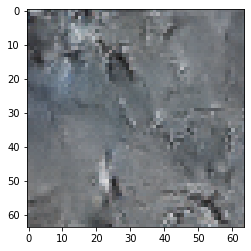

Time for epoch 1 is 7.50452446937561 sec
Gen loss: 7.5996910601773555, Disc loss: 0.06296310611343678, MSE loss: 30.102482240051437
Time for epoch 2 is 7.491322994232178 sec
Gen loss: 10.915349962911632, Disc loss: 0.11921928716855831, MSE loss: 31.45510065135594
Time for epoch 3 is 7.49472975730896 sec
Gen loss: 7.601161178857653, Disc loss: 0.09126124440816667, MSE loss: 31.000030734674716
Time for epoch 4 is 7.499961614608765 sec
Gen loss: 7.270909084537165, Disc loss: 0.07086167697350527, MSE loss: 30.66814162091511
Time for epoch 5 is 7.489482164382935 sec
Gen loss: 7.27559591438066, Disc loss: 0.05920450998404565, MSE loss: 30.059208128187393
Time for epoch 6 is 7.499951362609863 sec
Gen loss: 7.378035660358625, Disc loss: 0.05206944392413547, MSE loss: 29.760657235535827
Time for epoch 7 is 7.49758768081665 sec
Gen loss: 7.410401635053681, Disc loss: 0.05883821357309132, MSE loss: 30.09494330760263
Time for epoch 8 is 7.5032525062561035 sec
Gen loss: 7.325504228028501, Disc loss

Time for epoch 63 is 7.531327486038208 sec
Gen loss: 7.510227770663212, Disc loss: 0.06993272637179863, MSE loss: 30.391105698376165
Time for epoch 64 is 7.540635585784912 sec
Gen loss: 7.35717093459959, Disc loss: 0.054825198400934756, MSE loss: 29.82339501833205
Time for epoch 65 is 7.5515522956848145 sec
Gen loss: 7.569914852700582, Disc loss: 0.04607215150480908, MSE loss: 29.531944373112708
Time for epoch 66 is 7.427349090576172 sec
Gen loss: 7.734925416103869, Disc loss: 0.05932180204133435, MSE loss: 29.913081109685304
Time for epoch 67 is 7.543743371963501 sec
Gen loss: 7.377396813576137, Disc loss: 0.06215348698610192, MSE loss: 30.042372287450444
Time for epoch 68 is 7.538121223449707 sec
Gen loss: 8.08300735763095, Disc loss: 0.06823123024678303, MSE loss: 30.012762829540222
Time for epoch 69 is 7.52081823348999 sec
Gen loss: 8.337895787505277, Disc loss: 0.09473887271627021, MSE loss: 31.006043927779366
Time for epoch 70 is 7.523168563842773 sec
Gen loss: 7.5786344753048285

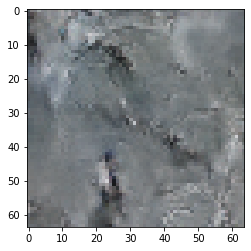

Time for epoch 1 is 7.493278503417969 sec
Gen loss: 8.723076511527788, Disc loss: 0.09367182539657423, MSE loss: 30.7590928581672
Time for epoch 2 is 7.5121705532073975 sec
Gen loss: 8.305520132628237, Disc loss: 0.10655622734536156, MSE loss: 31.334541610262903
Time for epoch 3 is 7.590020179748535 sec
Gen loss: 7.587585444049783, Disc loss: 0.07239217057380558, MSE loss: 30.944248468249146
Time for epoch 4 is 7.487414836883545 sec
Gen loss: 7.351496343690205, Disc loss: 0.07670773645272343, MSE loss: 30.754071682772338
Time for epoch 5 is 7.499897003173828 sec
Gen loss: 7.449090296013892, Disc loss: 0.06711029045871865, MSE loss: 30.17601810238226
Time for epoch 6 is 7.526514768600464 sec
Gen loss: 7.809910607531788, Disc loss: 0.049443850904857096, MSE loss: 29.85808163154416
Time for epoch 7 is 7.541142702102661 sec
Gen loss: 7.724720408276814, Disc loss: 0.0792174645242733, MSE loss: 30.462884075919465
Time for epoch 8 is 7.549193859100342 sec
Gen loss: 7.9553595144897296, Disc lo

Time for epoch 63 is 7.445851802825928 sec
Gen loss: 7.722177205693108, Disc loss: 0.0573496038790131, MSE loss: 30.025751036357104
Time for epoch 64 is 7.481813192367554 sec
Gen loss: 8.23793922336444, Disc loss: 0.07206547696258227, MSE loss: 30.236016627572738
Time for epoch 65 is 7.592268466949463 sec
Gen loss: 8.00228026113536, Disc loss: 0.07291508658043283, MSE loss: 30.560969872203298
Time for epoch 66 is 7.433554172515869 sec
Gen loss: 7.712987369961208, Disc loss: 0.0587115801311146, MSE loss: 30.017733710891186
Time for epoch 67 is 7.503276109695435 sec
Gen loss: 7.6648020808935815, Disc loss: 0.07333630136183279, MSE loss: 30.46538557140485
Time for epoch 68 is 7.498914480209351 sec
Gen loss: 7.605199025575384, Disc loss: 0.06645176794725725, MSE loss: 30.41192328186862
Time for epoch 69 is 7.506446361541748 sec
Gen loss: 7.472926763984246, Disc loss: 0.05640063549203894, MSE loss: 30.217298450831798
Time for epoch 70 is 7.5435404777526855 sec
Gen loss: 7.959833983806414, D

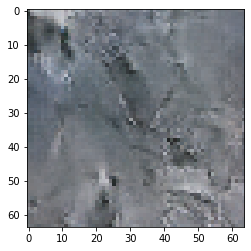

Time for epoch 1 is 7.447755575180054 sec
Gen loss: 7.570720459387554, Disc loss: 0.06239562333362091, MSE loss: 30.137348226738492
Time for epoch 2 is 7.567802906036377 sec
Gen loss: 9.36220931231491, Disc loss: 0.06300960788919142, MSE loss: 30.893014752767918
Time for epoch 3 is 7.52459979057312 sec
Gen loss: 7.55591069844357, Disc loss: 0.06625517474980848, MSE loss: 30.797376214004146
Time for epoch 4 is 7.523993492126465 sec
Gen loss: 7.488393233074405, Disc loss: 0.07564635665047419, MSE loss: 30.651598105908732
Time for epoch 5 is 7.50784707069397 sec
Gen loss: 7.3428404014608075, Disc loss: 0.05966849466829957, MSE loss: 30.37863202599006
Time for epoch 6 is 7.45879340171814 sec
Gen loss: 7.4522312249594584, Disc loss: 0.053908107315946044, MSE loss: 30.137942425280727
Time for epoch 7 is 7.461501598358154 sec
Gen loss: 7.488408335502232, Disc loss: 0.05360345549450501, MSE loss: 30.08596068798365
Time for epoch 8 is 7.50445556640625 sec
Gen loss: 8.05954564231521, Disc loss: 

Time for epoch 63 is 7.462392330169678 sec
Gen loss: 7.478910690400658, Disc loss: 0.07312449165380139, MSE loss: 30.98038380320479
Time for epoch 64 is 7.47832465171814 sec
Gen loss: 7.529570663524514, Disc loss: 0.0735897033738457, MSE loss: 30.489779009728572
Time for epoch 65 is 7.604787349700928 sec
Gen loss: 7.854813978924015, Disc loss: 0.05598077597293743, MSE loss: 29.89453682214587
Time for epoch 66 is 7.444256782531738 sec
Gen loss: 8.588927707051843, Disc loss: 0.1151887506505583, MSE loss: 31.505678657593766
Time for epoch 67 is 7.63226056098938 sec
Gen loss: 8.037959296528886, Disc loss: 0.0998928031012123, MSE loss: 31.18986536041508
Time for epoch 68 is 7.422254323959351 sec
Gen loss: 8.777241142138555, Disc loss: 0.06812114906475215, MSE loss: 30.570403494485994
Time for epoch 69 is 7.4677557945251465 sec
Gen loss: 9.295707074607291, Disc loss: 0.08311311182625729, MSE loss: 30.672480978616854
Time for epoch 70 is 7.507849931716919 sec
Gen loss: 7.9762214089473735, Dis

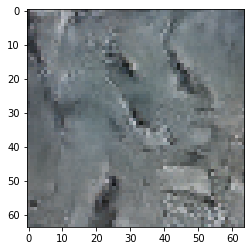

Time for epoch 1 is 7.404560804367065 sec
Gen loss: 7.620685736338298, Disc loss: 0.061015397342121316, MSE loss: 30.198249563615175
Time for epoch 2 is 7.481989145278931 sec
Gen loss: 7.6258138085445415, Disc loss: 0.060991520398084406, MSE loss: 30.290963480466104
Time for epoch 3 is 7.553079605102539 sec
Gen loss: 7.624044826683313, Disc loss: 0.052763218240910854, MSE loss: 30.061279203833603
Time for epoch 4 is 7.589899778366089 sec
Gen loss: 7.5232750303376985, Disc loss: 0.057545529362028794, MSE loss: 30.352420527760575
Time for epoch 5 is 7.420817852020264 sec
Gen loss: 8.055778146759282, Disc loss: 0.06974835537748189, MSE loss: 30.432001697984813
Time for epoch 6 is 7.549219846725464 sec
Gen loss: 8.925558166452216, Disc loss: 0.09183239792894299, MSE loss: 31.280750181616806
Time for epoch 7 is 7.537708282470703 sec
Gen loss: 7.520023322686916, Disc loss: 0.07188501132735453, MSE loss: 30.883211228905655
Time for epoch 8 is 7.44234299659729 sec
Gen loss: 7.569513130963333, 

Time for epoch 63 is 7.524243116378784 sec
Gen loss: 7.684060717016701, Disc loss: 0.054215262492558335, MSE loss: 29.954441768367115
Time for epoch 64 is 7.51240611076355 sec
Gen loss: 7.770316803681495, Disc loss: 0.06244940788871268, MSE loss: 29.827804203602035
Time for epoch 65 is 7.448741436004639 sec
Gen loss: 7.778956735037206, Disc loss: 0.05493100526298429, MSE loss: 29.80139294032482
Time for epoch 66 is 7.506925821304321 sec
Gen loss: 7.791383756208549, Disc loss: 0.05817501135687861, MSE loss: 29.95849466711525
Time for epoch 67 is 7.494527578353882 sec
Gen loss: 7.744434975673189, Disc loss: 0.0599085308805734, MSE loss: 30.19803296841257
Time for epoch 68 is 7.500489711761475 sec
Gen loss: 7.721772206831107, Disc loss: 0.06359605039247478, MSE loss: 30.436095405723343
Time for epoch 69 is 7.502391815185547 sec
Gen loss: 7.729150703605921, Disc loss: 0.060334569020707884, MSE loss: 30.53083416181528
Time for epoch 70 is 7.499382019042969 sec
Gen loss: 7.647432915240445, D

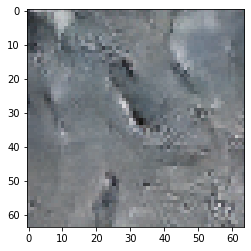

Time for epoch 1 is 7.53997802734375 sec
Gen loss: 8.083055564704626, Disc loss: 0.06469287957206146, MSE loss: 30.389346151171015
Time for epoch 2 is 7.454931974411011 sec
Gen loss: 9.091720550040888, Disc loss: 0.09058701123717398, MSE loss: 31.194356603028005
Time for epoch 3 is 7.467556476593018 sec
Gen loss: 8.518872317905995, Disc loss: 0.09623837033788318, MSE loss: 31.279197222495142
Time for epoch 4 is 7.504668951034546 sec
Gen loss: 8.647918578408921, Disc loss: 0.0789970407736624, MSE loss: 30.910840517783228
Time for epoch 5 is 7.516313791275024 sec
Gen loss: 7.812805664248582, Disc loss: 0.0661779887703573, MSE loss: 30.623227680278664
Time for epoch 6 is 7.519638538360596 sec
Gen loss: 7.684968728683182, Disc loss: 0.06147046432121175, MSE loss: 30.16951788925543
Time for epoch 7 is 7.519307851791382 sec
Gen loss: 8.122668328323984, Disc loss: 0.06349459912419397, MSE loss: 30.113189009793082
Time for epoch 8 is 7.509129047393799 sec
Gen loss: 7.601291461365656, Disc loss

Time for epoch 63 is 7.473259210586548 sec
Gen loss: 7.736510801444532, Disc loss: 0.046858671755116016, MSE loss: 30.019731878265134
Time for epoch 64 is 7.479794025421143 sec
Gen loss: 7.794368374315381, Disc loss: 0.06361782550590926, MSE loss: 30.29637544006513
Time for epoch 65 is 7.472382307052612 sec
Gen loss: 8.704289290317028, Disc loss: 0.07823580605082647, MSE loss: 30.45549189042916
Time for epoch 66 is 7.489419460296631 sec
Gen loss: 8.06557945830389, Disc loss: 0.10529340858328937, MSE loss: 31.222219673921746
Time for epoch 67 is 7.596966743469238 sec
Gen loss: 7.875651797628015, Disc loss: 0.06729684464651133, MSE loss: 30.74344996320523
Time for epoch 68 is 7.50477409362793 sec
Gen loss: 7.905747013040352, Disc loss: 0.06518794211393682, MSE loss: 30.381701182543747
Time for epoch 69 is 7.491311550140381 sec
Gen loss: 7.612803216226055, Disc loss: 0.06656906476716301, MSE loss: 30.50230878090794
Time for epoch 70 is 7.523761749267578 sec
Gen loss: 8.649431350108408, Di

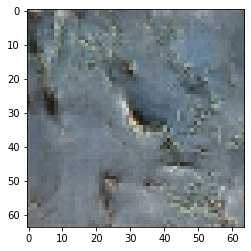

Time for epoch 1 is 7.465765714645386 sec
Gen loss: 9.226252271554012, Disc loss: 0.10669271972078986, MSE loss: 31.34663226740147
Time for epoch 2 is 7.504578351974487 sec
Gen loss: 7.934235459097679, Disc loss: 0.08331463767072378, MSE loss: 31.194090494295445
Time for epoch 3 is 7.603434085845947 sec
Gen loss: 7.6318148778383, Disc loss: 0.06751566075531862, MSE loss: 30.580474496856937
Time for epoch 4 is 7.4471306800842285 sec
Gen loss: 7.582668604243415, Disc loss: 0.05419837572450338, MSE loss: 30.248717770666936
Time for epoch 5 is 7.4791481494903564 sec
Gen loss: 7.5671553043169055, Disc loss: 0.06026386279205168, MSE loss: 30.312810861644383
Time for epoch 6 is 7.592769384384155 sec
Gen loss: 7.761913489520065, Disc loss: 0.06331354183293778, MSE loss: 30.288374949923053
Time for epoch 7 is 7.469728708267212 sec
Gen loss: 7.590800079872937, Disc loss: 0.05674558587159033, MSE loss: 30.231907154486432
Time for epoch 8 is 7.481844186782837 sec
Gen loss: 7.837981249904891, Disc 

Time for epoch 63 is 7.505066871643066 sec
Gen loss: 8.92291003901784, Disc loss: 0.10941397604156478, MSE loss: 31.425383828842865
Time for epoch 64 is 7.510663747787476 sec
Gen loss: 7.923364908068484, Disc loss: 0.08271149149149414, MSE loss: 30.918238042815915
Time for epoch 65 is 7.509402751922607 sec
Gen loss: 7.648562371892335, Disc loss: 0.0699980176674823, MSE loss: 30.71267165724178
Time for epoch 66 is 7.4989097118377686 sec
Gen loss: 8.580317074690408, Disc loss: 0.06308609876907266, MSE loss: 30.361352780970133
Time for epoch 67 is 7.50985860824585 sec
Gen loss: 8.307805646725786, Disc loss: 0.07180391954224012, MSE loss: 30.58536276261658
Time for epoch 68 is 7.509727478027344 sec
Gen loss: 7.880928595214678, Disc loss: 0.06079216346903111, MSE loss: 30.8329642898022
Time for epoch 69 is 7.532403945922852 sec
Gen loss: 7.901776853938736, Disc loss: 0.06214929923893465, MSE loss: 30.452484487518063
Time for epoch 70 is 7.5247557163238525 sec
Gen loss: 8.193019462471732, Di

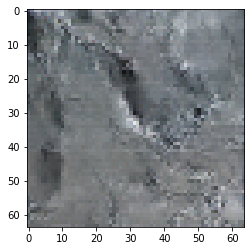

Time for epoch 1 is 7.5293495655059814 sec
Gen loss: 7.71012084723165, Disc loss: 0.05526813616165967, MSE loss: 30.248002711350356
Time for epoch 2 is 7.461058139801025 sec
Gen loss: 7.808089583223751, Disc loss: 0.059510547471507816, MSE loss: 30.334594618014204
Time for epoch 3 is 7.63058614730835 sec
Gen loss: 7.644433774922275, Disc loss: 0.05956061854977464, MSE loss: 30.363234584570577
Time for epoch 4 is 7.490768909454346 sec
Gen loss: 7.726779008622415, Disc loss: 0.05284213116625955, MSE loss: 30.010771485202035
Time for epoch 5 is 7.606501340866089 sec
Gen loss: 8.244336318194382, Disc loss: 0.06474366108792251, MSE loss: 30.09588931634174
Time for epoch 6 is 7.408442497253418 sec
Gen loss: 8.94164834888324, Disc loss: 0.07079210396345609, MSE loss: 30.654755181413357
Time for epoch 7 is 7.481629133224487 sec
Gen loss: 8.562753842775091, Disc loss: 0.06294788581020701, MSE loss: 30.428227442712966
Time for epoch 8 is 7.48000955581665 sec
Gen loss: 7.753495492909336, Disc los

Time for epoch 63 is 7.441072702407837 sec
Gen loss: 7.783042014775884, Disc loss: 0.05680617421826343, MSE loss: 30.420067433096207
Time for epoch 64 is 7.603394031524658 sec
Gen loss: 7.780926461465313, Disc loss: 0.058641789106874245, MSE loss: 30.561557935182318
Time for epoch 65 is 7.428416013717651 sec
Gen loss: 10.900844298727144, Disc loss: 0.10353010423440609, MSE loss: 31.409844778417572
Time for epoch 66 is 7.510512351989746 sec
Gen loss: 8.114705052156113, Disc loss: 0.08693058426658494, MSE loss: 31.460957245451972
Time for epoch 67 is 7.547055244445801 sec
Gen loss: 7.657612392249792, Disc loss: 0.06338294713031047, MSE loss: 30.47058843597164
Time for epoch 68 is 7.50508975982666 sec
Gen loss: 7.780254746517191, Disc loss: 0.05364391061813043, MSE loss: 30.229165141821554
Time for epoch 69 is 7.435976028442383 sec
Gen loss: 7.910049726646444, Disc loss: 0.04995845212079938, MSE loss: 29.80725035628652
Time for epoch 70 is 7.541839122772217 sec
Gen loss: 7.916267818874783

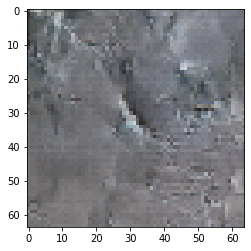

Time for epoch 1 is 7.539052963256836 sec
Gen loss: 8.047390254209358, Disc loss: 0.07792451493707069, MSE loss: 31.0459429319635
Time for epoch 2 is 7.4305737018585205 sec
Gen loss: 7.969465211801089, Disc loss: 0.05585041641841988, MSE loss: 30.393620948481367
Time for epoch 3 is 7.58189582824707 sec
Gen loss: 7.777396383001229, Disc loss: 0.05032740521521073, MSE loss: 30.253184274606266
Time for epoch 4 is 7.4239537715911865 sec
Gen loss: 7.764932065152218, Disc loss: 0.04461112767246585, MSE loss: 30.142662001819147
Time for epoch 5 is 7.505635976791382 sec
Gen loss: 7.948523264267258, Disc loss: 0.05263148290723522, MSE loss: 30.137473868806833
Time for epoch 6 is 7.517760753631592 sec
Gen loss: 7.989812345685674, Disc loss: 0.05740895470936195, MSE loss: 30.386930672456902
Time for epoch 7 is 7.451510667800903 sec
Gen loss: 8.150010965703949, Disc loss: 0.06276784425580541, MSE loss: 30.48712318441086
Time for epoch 8 is 7.567574739456177 sec
Gen loss: 8.81695465020694, Disc los

Time for epoch 63 is 7.426210403442383 sec
Gen loss: 8.362462733819232, Disc loss: 0.07613434818248974, MSE loss: 31.04948801076832
Time for epoch 64 is 7.598675489425659 sec
Gen loss: 8.062354719735742, Disc loss: 0.07480194903156143, MSE loss: 30.713257285637585
Time for epoch 65 is 7.450117349624634 sec
Gen loss: 8.075451181509953, Disc loss: 0.0479868047204699, MSE loss: 30.31578000386556
Time for epoch 66 is 7.454344034194946 sec
Gen loss: 7.944696925196867, Disc loss: 0.04855237400356736, MSE loss: 29.887124286434513
Time for epoch 67 is 7.461808204650879 sec
Gen loss: 7.923006647001437, Disc loss: 0.052893065511145525, MSE loss: 30.259816766754398
Time for epoch 68 is 7.556547403335571 sec
Gen loss: 7.825395168004643, Disc loss: 0.055214237734558046, MSE loss: 30.23467467600091
Time for epoch 69 is 7.479063510894775 sec
Gen loss: 8.56129650694891, Disc loss: 0.07028527658616968, MSE loss: 30.271101442455922
Time for epoch 70 is 7.47545313835144 sec
Gen loss: 9.769317939675597, D

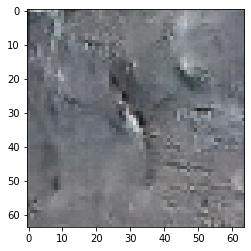

Time for epoch 1 is 7.474249839782715 sec
Gen loss: 9.252289187940478, Disc loss: 0.05852743901344216, MSE loss: 30.554881770436356
Time for epoch 2 is 7.468202114105225 sec
Gen loss: 7.9269271232894445, Disc loss: 0.055930731923137675, MSE loss: 30.35517977892868
Time for epoch 3 is 7.4838547706604 sec
Gen loss: 8.009058361777122, Disc loss: 0.05721984386663672, MSE loss: 30.446788095200287
Time for epoch 4 is 7.520119905471802 sec
Gen loss: 7.905099024940635, Disc loss: 0.05364906730200984, MSE loss: 30.4423761186884
Time for epoch 5 is 7.5924577713012695 sec
Gen loss: 8.129309530180644, Disc loss: 0.05250227782776867, MSE loss: 30.121811507517084
Time for epoch 6 is 7.450154781341553 sec
Gen loss: 8.402566120230409, Disc loss: 0.04634937417026493, MSE loss: 30.202376047770183
Time for epoch 7 is 7.5339250564575195 sec
Gen loss: 8.625225228668874, Disc loss: 0.06523351202359888, MSE loss: 30.689782641444427
Time for epoch 8 is 7.57637357711792 sec
Gen loss: 8.850798082222461, Disc lo

Time for epoch 63 is 7.460355520248413 sec
Gen loss: 8.084901835537215, Disc loss: 0.055593881417705666, MSE loss: 30.569660212612412
Time for epoch 64 is 7.440934896469116 sec
Gen loss: 8.37716302122204, Disc loss: 0.046414500031415826, MSE loss: 29.71730212596697
Time for epoch 65 is 7.453495740890503 sec
Gen loss: 8.204427801819675, Disc loss: 0.053098676531250034, MSE loss: 29.933953199929338
Time for epoch 66 is 7.451458692550659 sec
Gen loss: 8.41678674692707, Disc loss: 0.04619356736720307, MSE loss: 29.689605128797414
Time for epoch 67 is 7.4506731033325195 sec
Gen loss: 8.673010014583102, Disc loss: 0.059949992735705185, MSE loss: 30.221980609221834
Time for epoch 68 is 7.451365947723389 sec
Gen loss: 8.280944326705725, Disc loss: 0.04049723738486447, MSE loss: 29.83557863933284
Time for epoch 69 is 7.457080364227295 sec
Gen loss: 8.218075107429732, Disc loss: 0.048081435744277125, MSE loss: 29.873686700009394
Time for epoch 70 is 7.451542377471924 sec
Gen loss: 8.232302637281

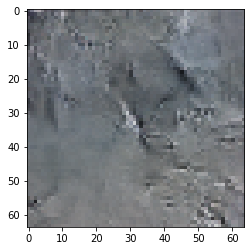

Time for epoch 1 is 7.479475259780884 sec
Gen loss: 8.009221022691184, Disc loss: 0.049510450488547, MSE loss: 30.046518253440134
Time for epoch 2 is 7.4991772174835205 sec
Gen loss: 8.306134822245859, Disc loss: 0.04864686637546433, MSE loss: 30.128600386746207
Time for epoch 3 is 7.493298292160034 sec
Gen loss: 8.650147549182096, Disc loss: 0.059073687091736035, MSE loss: 30.275903102182113
Time for epoch 4 is 7.497652530670166 sec
Gen loss: 9.935077858488087, Disc loss: 0.09267226621643923, MSE loss: 31.30068537084068
Time for epoch 5 is 7.535574913024902 sec
Gen loss: 8.228805284836104, Disc loss: 0.06368499235401491, MSE loss: 30.772697867416753
Time for epoch 6 is 7.507305145263672 sec
Gen loss: 7.988202690755125, Disc loss: 0.05535589896171192, MSE loss: 30.40281081781155
Time for epoch 7 is 7.484039068222046 sec
Gen loss: 7.969563374351357, Disc loss: 0.041648327941163306, MSE loss: 30.016612432836517
Time for epoch 8 is 7.499773740768433 sec
Gen loss: 8.240604347652859, Disc l

Time for epoch 63 is 7.581079006195068 sec
Gen loss: 8.5498655068519, Disc loss: 0.06699302364904232, MSE loss: 30.698336515969377
Time for epoch 64 is 7.426715135574341 sec
Gen loss: 8.596166637854848, Disc loss: 0.07809853273113246, MSE loss: 30.63511069486458
Time for epoch 65 is 7.592798471450806 sec
Gen loss: 7.931215376711796, Disc loss: 0.059086097260971165, MSE loss: 30.504113794342288
Time for epoch 66 is 7.580847978591919 sec
Gen loss: 8.190992354054439, Disc loss: 0.05652093712800765, MSE loss: 30.310292773776585
Time for epoch 67 is 7.51513409614563 sec
Gen loss: 8.110887532634786, Disc loss: 0.060279760817804076, MSE loss: 30.455037331516504
Time for epoch 68 is 7.4499194622039795 sec
Gen loss: 8.39852587511223, Disc loss: 0.05334117739131046, MSE loss: 30.189128519073734
Time for epoch 69 is 7.481525659561157 sec
Gen loss: 9.172151557798308, Disc loss: 0.06576874248603319, MSE loss: 30.209768843198532
Time for epoch 70 is 7.584389925003052 sec
Gen loss: 8.753240927771179,

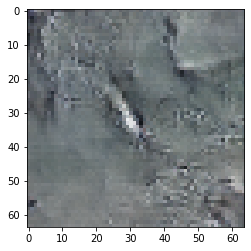

Time for epoch 1 is 7.552731513977051 sec
Gen loss: 8.887940205209624, Disc loss: 0.05734584748042687, MSE loss: 30.401505333298267
Time for epoch 2 is 7.509774446487427 sec
Gen loss: 9.13814758026826, Disc loss: 0.08650158729514948, MSE loss: 30.96441844226868
Time for epoch 3 is 7.507239818572998 sec
Gen loss: 8.371871909474939, Disc loss: 0.04707946731607356, MSE loss: 30.27993199108093
Time for epoch 4 is 7.495486497879028 sec
Gen loss: 8.068483861804332, Disc loss: 0.05427687847829073, MSE loss: 30.209613324503913
Time for epoch 5 is 7.519397020339966 sec
Gen loss: 7.969243352006122, Disc loss: 0.052710523503753014, MSE loss: 30.259798644357904
Time for epoch 6 is 7.488595247268677 sec
Gen loss: 8.008722249731463, Disc loss: 0.046497072729135065, MSE loss: 30.07250177957178
Time for epoch 7 is 7.5295326709747314 sec
Gen loss: 9.279987662142208, Disc loss: 0.0755119681708372, MSE loss: 30.49169699609441
Time for epoch 8 is 7.510751724243164 sec
Gen loss: 10.14749103639184, Disc los

Time for epoch 63 is 7.477408409118652 sec
Gen loss: 9.456505511834369, Disc loss: 0.06829586893998069, MSE loss: 30.6573249744529
Time for epoch 64 is 7.493313550949097 sec
Gen loss: 8.469157487719363, Disc loss: 0.06368769229246811, MSE loss: 30.935569334159375
Time for epoch 65 is 7.522865533828735 sec
Gen loss: 8.86525207871021, Disc loss: 0.03946146543173537, MSE loss: 29.844114686092386
Time for epoch 66 is 7.50922417640686 sec
Gen loss: 9.183509649623055, Disc loss: 0.05963259796248522, MSE loss: 30.335932082923126
Time for epoch 67 is 7.481227874755859 sec
Gen loss: 9.224021532994298, Disc loss: 0.04989765282147873, MSE loss: 29.9136679269434
Time for epoch 68 is 7.493400812149048 sec
Gen loss: 9.299091629865693, Disc loss: 0.0864676999637329, MSE loss: 30.98817038600684
Time for epoch 69 is 7.603972911834717 sec
Gen loss: 8.45436729648249, Disc loss: 0.0629782336263988, MSE loss: 30.457009431792468
Time for epoch 70 is 7.536692380905151 sec
Gen loss: 8.937078840364286, Disc lo

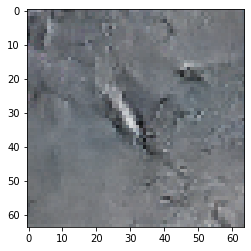

Time for epoch 1 is 7.607972145080566 sec
Gen loss: 8.401130615534175, Disc loss: 0.052918196741149566, MSE loss: 30.12880910444389
Time for epoch 2 is 7.390848636627197 sec
Gen loss: 8.418985745448085, Disc loss: 0.05391073312994022, MSE loss: 30.11047714770971
Time for epoch 3 is 7.5016257762908936 sec
Gen loss: 8.570879965939818, Disc loss: 0.04992115154400528, MSE loss: 29.912548380492503
Time for epoch 4 is 7.496073246002197 sec
Gen loss: 9.407774429011152, Disc loss: 0.05944268676521115, MSE loss: 30.34599474258216
Time for epoch 5 is 7.498227119445801 sec
Gen loss: 8.98078014275569, Disc loss: 0.07361043826613807, MSE loss: 30.741901775039633
Time for epoch 6 is 7.48974084854126 sec
Gen loss: 8.516124681405582, Disc loss: 0.06251942427471775, MSE loss: 30.56606546003967
Time for epoch 7 is 7.500655651092529 sec
Gen loss: 8.405351328655955, Disc loss: 0.05815225275568437, MSE loss: 30.483899062241964
Time for epoch 8 is 7.49484658241272 sec
Gen loss: 8.317494431162268, Disc loss:

Time for epoch 63 is 7.4245429039001465 sec
Gen loss: 8.391661220126682, Disc loss: 0.06466868673662622, MSE loss: 30.634048983979678
Time for epoch 64 is 7.4280290603637695 sec
Gen loss: 8.322186441602422, Disc loss: 0.0538073371142101, MSE loss: 30.503310583471283
Time for epoch 65 is 7.541933298110962 sec
Gen loss: 8.3271876725401, Disc loss: 0.05592360327633598, MSE loss: 30.502252087683537
Time for epoch 66 is 7.526498556137085 sec
Gen loss: 8.124794493522748, Disc loss: 0.044049973060127076, MSE loss: 30.325652223292405
Time for epoch 67 is 7.431720018386841 sec
Gen loss: 8.094386808917452, Disc loss: 0.04173323823038746, MSE loss: 30.053275664001298
Time for epoch 68 is 7.588249206542969 sec
Gen loss: 9.725147631110215, Disc loss: 0.06413418514133326, MSE loss: 30.565742471999915
Time for epoch 69 is 7.413483619689941 sec
Gen loss: 8.745159349467373, Disc loss: 0.06422206794132912, MSE loss: 30.951697993084668
Time for epoch 70 is 7.465366840362549 sec
Gen loss: 8.47984517105226

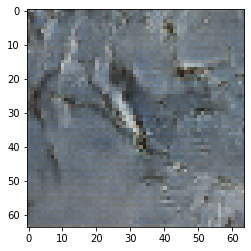

Time for epoch 1 is 7.4643237590789795 sec
Gen loss: 10.27873182296753, Disc loss: 0.07833229798432902, MSE loss: 31.508714924013713
Time for epoch 2 is 7.58188796043396 sec
Gen loss: 8.405451867638565, Disc loss: 0.06102659854052656, MSE loss: 30.936395557269172
Time for epoch 3 is 7.486595630645752 sec
Gen loss: 8.107694118003534, Disc loss: 0.05214616741438025, MSE loss: 30.660678269094245
Time for epoch 4 is 7.4674272537231445 sec
Gen loss: 8.22396896331291, Disc loss: 0.0413345709174296, MSE loss: 30.034904211194213
Time for epoch 5 is 7.479899644851685 sec
Gen loss: 8.651721007132595, Disc loss: 0.048449041430046844, MSE loss: 30.180204758476112
Time for epoch 6 is 7.520675420761108 sec
Gen loss: 8.682303946838793, Disc loss: 0.04864689381848352, MSE loss: 30.033151549052416
Time for epoch 7 is 7.598064184188843 sec
Gen loss: 8.632322865773023, Disc loss: 0.04637792219875884, MSE loss: 30.018244906169613
Time for epoch 8 is 7.411557197570801 sec
Gen loss: 8.659676845157696, Disc 

Time for epoch 63 is 7.538266181945801 sec
Gen loss: 8.222625077255373, Disc loss: 0.05219770224669035, MSE loss: 30.254681543283024
Time for epoch 64 is 7.417096138000488 sec
Gen loss: 8.193449955968676, Disc loss: 0.042584725916839955, MSE loss: 29.951010422331855
Time for epoch 65 is 7.506378889083862 sec
Gen loss: 8.828505473408272, Disc loss: 0.0580513616164119, MSE loss: 30.21010162126081
Time for epoch 66 is 7.507205247879028 sec
Gen loss: 9.020981033966148, Disc loss: 0.04659908933526058, MSE loss: 29.99691810194393
Time for epoch 67 is 7.511596441268921 sec
Gen loss: 8.708788676636653, Disc loss: 0.05774300918842762, MSE loss: 30.34203988362134
Time for epoch 68 is 7.509365558624268 sec
Gen loss: 8.395449690056363, Disc loss: 0.05299138939538138, MSE loss: 30.659397311326934
Time for epoch 69 is 7.449265003204346 sec
Gen loss: 8.454287145195938, Disc loss: 0.05239095876758747, MSE loss: 30.43397866225824
Time for epoch 70 is 7.491422414779663 sec
Gen loss: 8.452902448855765, D

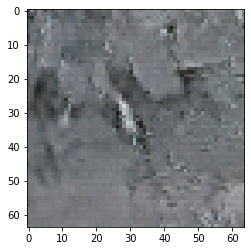

Time for epoch 1 is 7.488800287246704 sec
Gen loss: 8.588579946740209, Disc loss: 0.05092679837079426, MSE loss: 30.618556919459728
Time for epoch 2 is 7.580991744995117 sec
Gen loss: 8.17786065414346, Disc loss: 0.04564992818624276, MSE loss: 30.040614311611105
Time for epoch 3 is 7.469688892364502 sec
Gen loss: 8.851551455210863, Disc loss: 0.04126557698937103, MSE loss: 30.16266875021503
Time for epoch 4 is 7.4564666748046875 sec
Gen loss: 8.606908272275433, Disc loss: 0.06047481742733585, MSE loss: 30.38179016630178
Time for epoch 5 is 7.564274311065674 sec
Gen loss: 8.819402098978761, Disc loss: 0.04770775577269538, MSE loss: 30.44710361925244
Time for epoch 6 is 7.581575155258179 sec
Gen loss: 9.214184652499068, Disc loss: 0.06172261107902277, MSE loss: 30.474769282147168
Time for epoch 7 is 7.442894697189331 sec
Gen loss: 8.82645945045037, Disc loss: 0.045315413065156886, MSE loss: 30.228517775290058
Time for epoch 8 is 7.467162609100342 sec
Gen loss: 8.34910920125036, Disc loss

Time for epoch 63 is 7.607747793197632 sec
Gen loss: 8.418457157889678, Disc loss: 0.041149056860628135, MSE loss: 30.008936708858666
Time for epoch 64 is 7.503165006637573 sec
Gen loss: 8.691533203693586, Disc loss: 0.04236559496042861, MSE loss: 30.01834783579922
Time for epoch 65 is 7.468635320663452 sec
Gen loss: 8.971389102418895, Disc loss: 0.05895115069330097, MSE loss: 30.19839964972602
Time for epoch 66 is 7.52521824836731 sec
Gen loss: 8.781021623430536, Disc loss: 0.05048610971291577, MSE loss: 30.09640012394768
Time for epoch 67 is 7.561831474304199 sec
Gen loss: 8.446261654055215, Disc loss: 0.04842644929459954, MSE loss: 30.25323287839812
Time for epoch 68 is 7.541526794433594 sec
Gen loss: 8.624129257874115, Disc loss: 0.04283085557001802, MSE loss: 30.22727669093021
Time for epoch 69 is 7.463503360748291 sec
Gen loss: 8.756415093171242, Disc loss: 0.051712878990942374, MSE loss: 30.351510252086772
Time for epoch 70 is 7.506459474563599 sec
Gen loss: 10.584659096994374, 

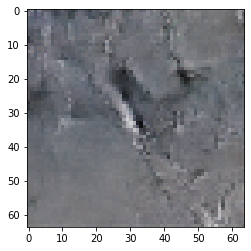

Time for epoch 1 is 7.546338319778442 sec
Gen loss: 8.863113845266946, Disc loss: 0.04563511812378467, MSE loss: 30.183624474336785
Time for epoch 2 is 7.49016547203064 sec
Gen loss: 10.422802350062343, Disc loss: 0.06836125842837991, MSE loss: 30.15089995945049
Time for epoch 3 is 7.498826742172241 sec
Gen loss: 9.515075785680837, Disc loss: 0.08434331769019247, MSE loss: 31.1106154899287
Time for epoch 4 is 7.491986989974976 sec
Gen loss: 9.115002462857461, Disc loss: 0.05567340351840567, MSE loss: 30.592498427807154
Time for epoch 5 is 7.509825944900513 sec
Gen loss: 8.822015046427243, Disc loss: 0.05095290765182057, MSE loss: 30.284858445164957
Time for epoch 6 is 7.501194000244141 sec
Gen loss: 8.662900986710214, Disc loss: 0.033188017341055906, MSE loss: 29.910887503688574
Time for epoch 7 is 7.5083372592926025 sec
Gen loss: 8.757948613102197, Disc loss: 0.04903158327546614, MSE loss: 30.030163607300135
Time for epoch 8 is 7.513631820678711 sec
Gen loss: 8.593640050913907, Disc l

Time for epoch 63 is 7.5572991371154785 sec
Gen loss: 8.719935216877841, Disc loss: 0.04818913667446361, MSE loss: 30.182198651114778
Time for epoch 64 is 7.407182455062866 sec
Gen loss: 8.614379688976257, Disc loss: 0.051183831359185326, MSE loss: 30.31841214497884
Time for epoch 65 is 7.527723550796509 sec
Gen loss: 8.610674028474142, Disc loss: 0.04637631385471687, MSE loss: 30.211524601551254
Time for epoch 66 is 7.481244087219238 sec
Gen loss: 8.73685776056636, Disc loss: 0.039277209411943105, MSE loss: 29.8697632528579
Time for epoch 67 is 7.482220888137817 sec
Gen loss: 8.727538900969797, Disc loss: 0.05086441687189944, MSE loss: 30.153633980893183
Time for epoch 68 is 7.478070497512817 sec
Gen loss: 10.560676659994979, Disc loss: 0.07276577884403908, MSE loss: 30.31759748484707
Time for epoch 69 is 7.578885078430176 sec
Gen loss: 11.111467061650139, Disc loss: 0.07537451316448728, MSE loss: 31.194224463568794
Time for epoch 70 is 7.4547600746154785 sec
Gen loss: 9.3041990430051

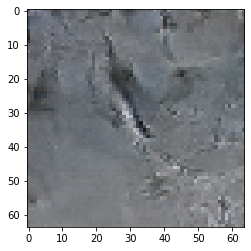

Time for epoch 1 is 7.532009124755859 sec
Gen loss: 8.44331311921117, Disc loss: 0.04336256082893758, MSE loss: 30.05669592777242
Time for epoch 2 is 7.599042892456055 sec
Gen loss: 8.654417298996675, Disc loss: 0.04676733044413711, MSE loss: 29.89007452574526
Time for epoch 3 is 7.684940576553345 sec
Gen loss: 8.731190423009195, Disc loss: 0.039368473394517725, MSE loss: 29.980153313820278
Time for epoch 4 is 7.642246961593628 sec
Gen loss: 8.988837830096402, Disc loss: 0.04370829442021125, MSE loss: 29.960600106050652
Time for epoch 5 is 7.674747943878174 sec
Gen loss: 8.93508236324238, Disc loss: 0.04327972171901344, MSE loss: 30.316090317599496
Time for epoch 6 is 7.518049001693726 sec
Gen loss: 8.93415188983204, Disc loss: 0.054000778266337264, MSE loss: 30.31469782904235
Time for epoch 7 is 7.524734020233154 sec
Gen loss: 8.885212938313884, Disc loss: 0.04964673153585679, MSE loss: 30.34764214905943
Time for epoch 8 is 7.5305516719818115 sec
Gen loss: 8.905348379760577, Disc loss

Time for epoch 63 is 7.5767905712127686 sec
Gen loss: 8.587861933359285, Disc loss: 0.04350475444260298, MSE loss: 30.21404971921347
Time for epoch 64 is 7.468984603881836 sec
Gen loss: 8.980172529453185, Disc loss: 0.052367042984055014, MSE loss: 30.28139832866224
Time for epoch 65 is 7.490771055221558 sec
Gen loss: 8.920947090397036, Disc loss: 0.055085298066802936, MSE loss: 30.48846700197959
Time for epoch 66 is 7.464858293533325 sec
Gen loss: 8.723658100376284, Disc loss: 0.048385505376637314, MSE loss: 30.373321331613433
Time for epoch 67 is 7.473036766052246 sec
Gen loss: 10.055857768226769, Disc loss: 0.05916571050615278, MSE loss: 30.567477538979798
Time for epoch 68 is 7.48386025428772 sec
Gen loss: 9.759247455493545, Disc loss: 0.0631833959279833, MSE loss: 30.69926666631931
Time for epoch 69 is 7.47952938079834 sec
Gen loss: 8.929565283664196, Disc loss: 0.059108480750229765, MSE loss: 30.73768817312349
Time for epoch 70 is 7.519972085952759 sec
Gen loss: 8.750013724898258,

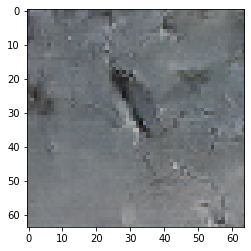

Time for epoch 1 is 7.4497151374816895 sec
Gen loss: 9.903060335453933, Disc loss: 0.054060085690395845, MSE loss: 30.137415154516535
Time for epoch 2 is 7.458348274230957 sec
Gen loss: 9.080065075944109, Disc loss: 0.05854973688798636, MSE loss: 30.190895809390682
Time for epoch 3 is 7.4635725021362305 sec
Gen loss: 8.943780528174507, Disc loss: 0.04470866093292787, MSE loss: 30.101725725623652
Time for epoch 4 is 7.505741834640503 sec
Gen loss: 9.096703878263147, Disc loss: 0.05090105504543346, MSE loss: 30.154472020260364
Time for epoch 5 is 7.552551507949829 sec
Gen loss: 8.961050232574546, Disc loss: 0.04648971690958477, MSE loss: 30.23120954043174
Time for epoch 6 is 7.467609643936157 sec
Gen loss: 9.042783326249781, Disc loss: 0.051178345048161565, MSE loss: 30.20463966224898
Time for epoch 7 is 7.453148603439331 sec
Gen loss: 8.855705258645985, Disc loss: 0.04693174644947231, MSE loss: 30.177560646036454
Time for epoch 8 is 7.611304759979248 sec
Gen loss: 9.930205222390855, Dis

Time for epoch 63 is 7.439791679382324 sec
Gen loss: 8.816883030299572, Disc loss: 0.03987900012238696, MSE loss: 29.89385743903597
Time for epoch 64 is 7.601582288742065 sec
Gen loss: 9.12572157350659, Disc loss: 0.04849274995939321, MSE loss: 29.7814799983327
Time for epoch 65 is 7.4701454639434814 sec
Gen loss: 9.395896969771966, Disc loss: 0.0443967568604214, MSE loss: 29.971947507160465
Time for epoch 66 is 7.549731016159058 sec
Gen loss: 9.095339892679437, Disc loss: 0.04951651717758886, MSE loss: 30.06660357529555
Time for epoch 67 is 7.4176928997039795 sec
Gen loss: 9.721497348330532, Disc loss: 0.04905696162704106, MSE loss: 30.103698782158414
Time for epoch 68 is 7.473358631134033 sec
Gen loss: 9.266970590524235, Disc loss: 0.06259422388409207, MSE loss: 30.445002992624836
Time for epoch 69 is 7.5769407749176025 sec
Gen loss: 8.865921835912275, Disc loss: 0.04701092388123768, MSE loss: 30.51204124698794
Time for epoch 70 is 7.429726600646973 sec
Gen loss: 8.759423998959342, D

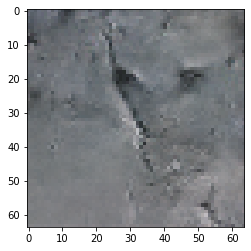

Time for epoch 1 is 7.4535908699035645 sec
Gen loss: 8.932942917676476, Disc loss: 0.043099737361210415, MSE loss: 29.995579256920955
Time for epoch 2 is 7.589077711105347 sec
Gen loss: 9.340750815745615, Disc loss: 0.04614156787827937, MSE loss: 29.966499840340962
Time for epoch 3 is 7.431191921234131 sec
Gen loss: 11.076977497193871, Disc loss: 0.0751371425218604, MSE loss: 30.739554459486552
Time for epoch 4 is 7.4676549434661865 sec
Gen loss: 9.10020006252175, Disc loss: 0.05559002951880397, MSE loss: 30.689583755121
Time for epoch 5 is 7.6064112186431885 sec
Gen loss: 8.808390280095542, Disc loss: 0.04474838066640749, MSE loss: 30.62270298365978
Time for epoch 6 is 7.3902199268341064 sec
Gen loss: 8.50128224096324, Disc loss: 0.0404404256233206, MSE loss: 30.274241093374528
Time for epoch 7 is 7.528307914733887 sec
Gen loss: 8.722216787053963, Disc loss: 0.050330979327752, MSE loss: 30.360102795649997
Time for epoch 8 is 7.4905736446380615 sec
Gen loss: 8.876192258302435, Disc los

Time for epoch 63 is 7.485337734222412 sec
Gen loss: 9.42374516954913, Disc loss: 0.06182342902728834, MSE loss: 30.408849612807195
Time for epoch 64 is 7.483732461929321 sec
Gen loss: 8.86672059759538, Disc loss: 0.04185667634467773, MSE loss: 30.2218282539347
Time for epoch 65 is 7.607987880706787 sec
Gen loss: 9.382761192838673, Disc loss: 0.05161170886818769, MSE loss: 30.301722710048605
Time for epoch 66 is 7.430837631225586 sec
Gen loss: 8.971508970751671, Disc loss: 0.044723163799052744, MSE loss: 30.44666605073262
Time for epoch 67 is 7.456888675689697 sec
Gen loss: 8.849310491143203, Disc loss: 0.044796921595407976, MSE loss: 30.574386669045218
Time for epoch 68 is 7.549181222915649 sec
Gen loss: 8.803367773691813, Disc loss: 0.047100952676149416, MSE loss: 30.381719397981637
Time for epoch 69 is 7.60769248008728 sec
Gen loss: 9.067576062065475, Disc loss: 0.04832268537072336, MSE loss: 30.28334039724293
Time for epoch 70 is 7.4022345542907715 sec
Gen loss: 8.99351712875573, D

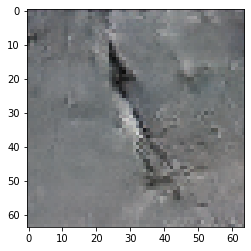

Time for epoch 1 is 7.595489740371704 sec
Gen loss: 8.791484889622303, Disc loss: 0.04450802640045481, MSE loss: 30.103728617432964
Time for epoch 2 is 7.465459585189819 sec
Gen loss: 9.356176761430776, Disc loss: 0.04641972711773717, MSE loss: 30.172398300997934
Time for epoch 3 is 7.459601879119873 sec
Gen loss: 9.068662966493022, Disc loss: 0.04358456674098797, MSE loss: 30.14158809217334
Time for epoch 4 is 7.464538097381592 sec
Gen loss: 10.023195289983981, Disc loss: 0.056018707775927296, MSE loss: 30.515461810559117
Time for epoch 5 is 7.4679765701293945 sec
Gen loss: 9.730191774807649, Disc loss: 0.061989034216713444, MSE loss: 31.084255016916167
Time for epoch 6 is 7.571202516555786 sec
Gen loss: 8.780738786630192, Disc loss: 0.04708028799708463, MSE loss: 30.593731758717276
Time for epoch 7 is 7.443312406539917 sec
Gen loss: 8.837623438537928, Disc loss: 0.04157407081378044, MSE loss: 30.45615071655935
Time for epoch 8 is 7.469028949737549 sec
Gen loss: 9.221133626250394, Dis

Time for epoch 63 is 7.5033135414123535 sec
Gen loss: 8.755367611158832, Disc loss: 0.05094850197264692, MSE loss: 30.32413136345261
Time for epoch 64 is 7.501810073852539 sec
Gen loss: 8.965125198932844, Disc loss: 0.04391552394443396, MSE loss: 30.198970665453572
Time for epoch 65 is 7.527330636978149 sec
Gen loss: 8.726485395819191, Disc loss: 0.04326887089602314, MSE loss: 30.219680532853456
Time for epoch 66 is 7.4881579875946045 sec
Gen loss: 9.344210266743895, Disc loss: 0.0546092329244571, MSE loss: 30.28573422315644
Time for epoch 67 is 7.501078844070435 sec
Gen loss: 9.76825089829401, Disc loss: 0.09265432391669992, MSE loss: 31.336265134940625
Time for epoch 68 is 7.49926233291626 sec
Gen loss: 9.014196618139582, Disc loss: 0.059125074241035885, MSE loss: 30.871052455126755
Time for epoch 69 is 7.482746839523315 sec
Gen loss: 8.795041265203377, Disc loss: 0.054521180564401354, MSE loss: 30.816005360466356
Time for epoch 70 is 7.508967161178589 sec
Gen loss: 8.660944459238026

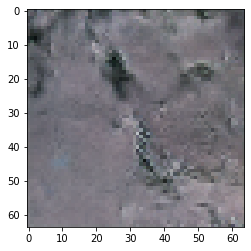

Time for epoch 1 is 7.515212059020996 sec
Gen loss: 9.940396365757557, Disc loss: 0.08421624317004277, MSE loss: 31.1117132750307
Time for epoch 2 is 7.509790420532227 sec
Gen loss: 8.677597075619994, Disc loss: 0.05249332759800988, MSE loss: 30.78915557241052
Time for epoch 3 is 7.516479730606079 sec
Gen loss: 8.559303197111218, Disc loss: 0.03487664501124054, MSE loss: 30.17825119928293
Time for epoch 4 is 7.462777137756348 sec
Gen loss: 8.573894620910893, Disc loss: 0.04623732849391465, MSE loss: 30.234790078346645
Time for epoch 5 is 7.493208885192871 sec
Gen loss: 9.060533991351036, Disc loss: 0.04961058294096442, MSE loss: 30.295364803738064
Time for epoch 6 is 7.487060546875 sec
Gen loss: 10.100625415481526, Disc loss: 0.0567847580564881, MSE loss: 30.04209396961905
Time for epoch 7 is 7.502134799957275 sec
Gen loss: 10.500526027627753, Disc loss: 0.06762074565179794, MSE loss: 30.642203452464365
Time for epoch 8 is 7.492695569992065 sec
Gen loss: 9.229348140034249, Disc loss: 0

Time for epoch 63 is 7.508907794952393 sec
Gen loss: 9.542178628244374, Disc loss: 0.0481130343234923, MSE loss: 30.226280667271393
Time for epoch 64 is 7.510932922363281 sec
Gen loss: 10.564972152554892, Disc loss: 0.059918836779916655, MSE loss: 30.602076646758288
Time for epoch 65 is 7.463024377822876 sec
Gen loss: 10.77551669609256, Disc loss: 0.07055746480738327, MSE loss: 30.904409982324616
Time for epoch 66 is 7.551419019699097 sec
Gen loss: 10.439947628393405, Disc loss: 0.0798485637907848, MSE loss: 31.37225422432752
Time for epoch 67 is 7.4752607345581055 sec
Gen loss: 8.954575304739521, Disc loss: 0.0646511918520394, MSE loss: 31.095621734453733
Time for epoch 68 is 7.442036867141724 sec
Gen loss: 8.822790833346566, Disc loss: 0.047532047007909944, MSE loss: 30.313962011156367
Time for epoch 69 is 7.487192869186401 sec
Gen loss: 8.816041323550671, Disc loss: 0.05407804529960135, MSE loss: 30.559831676121327
Time for epoch 70 is 7.488000392913818 sec
Gen loss: 8.8115060478045

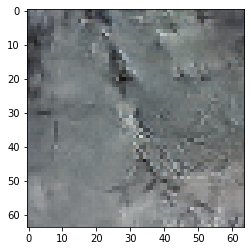

Time for epoch 1 is 7.41845703125 sec
Gen loss: 8.808532566235964, Disc loss: 0.036999647607563094, MSE loss: 30.43567622321731
Time for epoch 2 is 7.450119495391846 sec
Gen loss: 8.369966295030382, Disc loss: 0.03797139421463149, MSE loss: 30.205668658744997
Time for epoch 3 is 7.536883592605591 sec
Gen loss: 8.875412917718656, Disc loss: 0.043346239008428405, MSE loss: 30.23525532668199
Time for epoch 4 is 7.453290700912476 sec
Gen loss: 9.042775561169881, Disc loss: 0.04466879978677546, MSE loss: 30.44969304919566
Time for epoch 5 is 7.459774971008301 sec
Gen loss: 9.060439859302386, Disc loss: 0.05040835183231175, MSE loss: 30.591264766083178
Time for epoch 6 is 7.606251001358032 sec
Gen loss: 8.867814715315657, Disc loss: 0.04368857328157221, MSE loss: 30.375423312510254
Time for epoch 7 is 7.418486833572388 sec
Gen loss: 8.813036943192728, Disc loss: 0.036684220335663986, MSE loss: 30.27762137002092
Time for epoch 8 is 7.507853031158447 sec
Gen loss: 8.875481033066746, Disc loss:

Time for epoch 63 is 7.452237367630005 sec
Gen loss: 9.321570625150107, Disc loss: 0.05895548943500539, MSE loss: 30.6306927792102
Time for epoch 64 is 7.5766518115997314 sec
Gen loss: 8.92313175666623, Disc loss: 0.04419171952017517, MSE loss: 30.43510857248694
Time for epoch 65 is 7.431880235671997 sec
Gen loss: 8.728673835433918, Disc loss: 0.032736613601162215, MSE loss: 30.342045595329306
Time for epoch 66 is 7.5931031703948975 sec
Gen loss: 9.009786997384172, Disc loss: 0.03881318859800477, MSE loss: 30.14689621240466
Time for epoch 67 is 7.381313323974609 sec
Gen loss: 9.141781746210444, Disc loss: 0.03785007628859879, MSE loss: 30.169216476481783
Time for epoch 68 is 7.487418174743652 sec
Gen loss: 9.238815236543898, Disc loss: 0.04230063970672057, MSE loss: 30.384414161123882
Time for epoch 69 is 7.48129677772522 sec
Gen loss: 9.0756241932794, Disc loss: 0.036077533149618535, MSE loss: 30.069692658215033
Time for epoch 70 is 7.510017395019531 sec
Gen loss: 9.56256114628903, Di

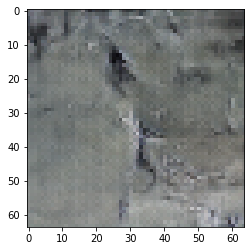

Time for epoch 1 is 7.444953203201294 sec
Gen loss: 9.395670808104642, Disc loss: 0.0647421527654248, MSE loss: 31.30351364321825
Time for epoch 2 is 7.449410676956177 sec
Gen loss: 8.999050159764483, Disc loss: 0.04308580038539035, MSE loss: 30.553870922181666
Time for epoch 3 is 7.60145378112793 sec
Gen loss: 8.957820124742462, Disc loss: 0.04036789298165453, MSE loss: 30.45949300647105
Time for epoch 4 is 7.425977945327759 sec
Gen loss: 9.716164875805863, Disc loss: 0.05097832017665575, MSE loss: 30.359557278434114
Time for epoch 5 is 7.539404630661011 sec
Gen loss: 11.00931346061107, Disc loss: 0.07324212677232028, MSE loss: 30.752697626749676
Time for epoch 6 is 7.491542100906372 sec
Gen loss: 9.537912911515894, Disc loss: 0.059249096321633596, MSE loss: 30.539357012203393
Time for epoch 7 is 7.502061605453491 sec
Gen loss: 11.243881268229911, Disc loss: 0.05030731294801333, MSE loss: 30.207020793180803
Time for epoch 8 is 7.440922260284424 sec
Gen loss: 9.600514458446968, Disc lo

Time for epoch 63 is 7.46320915222168 sec
Gen loss: 8.63194011285053, Disc loss: 0.036311995531627936, MSE loss: 30.33285292441929
Time for epoch 64 is 7.461822748184204 sec
Gen loss: 8.862754744242846, Disc loss: 0.04002498638271013, MSE loss: 30.27957976219777
Time for epoch 65 is 7.4564478397369385 sec
Gen loss: 8.86693860004911, Disc loss: 0.037326289842875046, MSE loss: 30.268488602263496
Time for epoch 66 is 7.466341018676758 sec
Gen loss: 8.823003519518265, Disc loss: 0.036506498694990265, MSE loss: 29.976349404187708
Time for epoch 67 is 7.45714545249939 sec
Gen loss: 10.370910975345105, Disc loss: 0.05768752423868935, MSE loss: 30.057925516350807
Time for epoch 68 is 7.476990461349487 sec
Gen loss: 9.733996838411988, Disc loss: 0.06882105550298018, MSE loss: 31.069555866685985
Time for epoch 69 is 7.615185260772705 sec
Gen loss: 9.052296938288826, Disc loss: 0.04810811636634556, MSE loss: 30.822684466354247
Time for epoch 70 is 7.4196836948394775 sec
Gen loss: 8.77572441488746

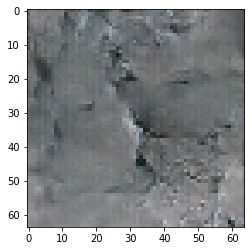

Time for epoch 1 is 7.441856622695923 sec
Gen loss: 9.445975052955028, Disc loss: 0.05235717049058461, MSE loss: 30.775611789568977
Time for epoch 2 is 7.487768888473511 sec
Gen loss: 9.47870091564933, Disc loss: 0.04373402885013218, MSE loss: 30.416618450547297
Time for epoch 3 is 7.528476715087891 sec
Gen loss: 8.935503773572968, Disc loss: 0.04192273687021706, MSE loss: 30.34209462297641
Time for epoch 4 is 7.519642114639282 sec
Gen loss: 8.832642214085029, Disc loss: 0.042587438758839205, MSE loss: 30.341534275995684
Time for epoch 5 is 7.418206214904785 sec
Gen loss: 9.21196752512035, Disc loss: 0.036066882888301274, MSE loss: 29.959996453468715
Time for epoch 6 is 7.498433828353882 sec
Gen loss: 9.080276910528582, Disc loss: 0.040286477474712826, MSE loss: 30.217519279417953
Time for epoch 7 is 7.4947509765625 sec
Gen loss: 9.533180990193271, Disc loss: 0.03809007900388205, MSE loss: 30.110715266488754
Time for epoch 8 is 7.494699478149414 sec
Gen loss: 9.95431357153709, Disc los

Time for epoch 63 is 7.4125847816467285 sec
Gen loss: 9.653312736087376, Disc loss: 0.048449027042777267, MSE loss: 30.675434190083326
Time for epoch 64 is 7.603585243225098 sec
Gen loss: 9.588305517263851, Disc loss: 0.05284415178195268, MSE loss: 30.424773373901036
Time for epoch 65 is 7.431257724761963 sec
Gen loss: 9.039660570098132, Disc loss: 0.04265865327455646, MSE loss: 30.359185495350744
Time for epoch 66 is 7.608267307281494 sec
Gen loss: 9.008093353209457, Disc loss: 0.04516871495716284, MSE loss: 30.458552507850214
Time for epoch 67 is 7.396438121795654 sec
Gen loss: 9.057594035699115, Disc loss: 0.04587766429728659, MSE loss: 30.516850034718914
Time for epoch 68 is 7.586994409561157 sec
Gen loss: 9.223790132579442, Disc loss: 0.04095212869603423, MSE loss: 30.316624090923526
Time for epoch 69 is 7.453885078430176 sec
Gen loss: 9.535404467647314, Disc loss: 0.04719070308339901, MSE loss: 30.365519645091318
Time for epoch 70 is 7.529863119125366 sec
Gen loss: 9.205486615498

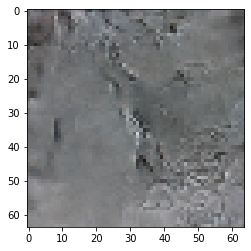

In [34]:
noise = np.random.normal(0, 1, 200)

gen_loss_hist = []
disc_loss_hist = []
mse_loss_hist = []

for i in range(40):
    gen_temp, disc_temp, mse_temp = train(train_imgs, 100)
    gen_loss_hist += gen_temp
    disc_loss_hist += disc_temp
    mse_loss_hist += mse_temp
    generated_image = generator.predict(np.array([noise]))[0]
    plt.imshow(unnormalize_img(generated_image))
    plt.savefig('./results/prog-imgs/bird-gan-mse/' + str((i+1)*100) + '.png')
    plt.show()
    generator.save_weights('./results/weights/bird-gan-mse/gen_weights_mse_' + str((i+1)*100) + '.h5')
    discriminator.save_weights('./results/weights/bird-gan-mse/disc_weights_mse_' + str((i+1)*100) + '.h5')

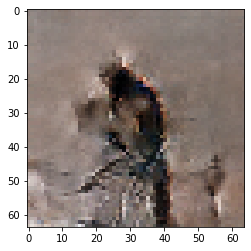

In [143]:
noise = np.random.normal(0, 1, 200)

generated_image = generator.predict(np.array([noise]))[0]
plt.imshow(unnormalize_img(generated_image))
plt.savefig('./results/test.png')
plt.show()

In [29]:
[1,2,30] + [4,5]

[1, 2, 30, 4, 5]

In [46]:
import matplotlib.pyplot  as plt

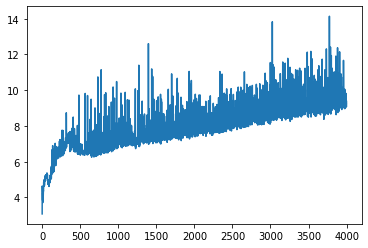

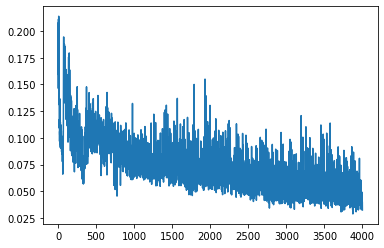

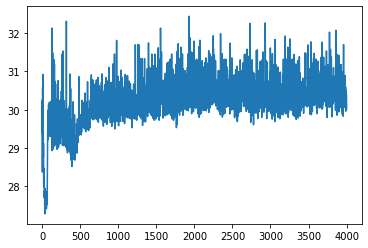

In [47]:
plt.plot(gen_loss_hist)
plt.show()

plt.plot(disc_loss_hist)
plt.show()

plt.plot(mse_loss_hist)
plt.show()
